# Parte 2: Preparação e Análise dos Dados


In [242]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import pygal as pg

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from sklearn.decomposition import PCA
import xgboost as xgb

def pgr(chart_object, nome_arquivo):
    """
    Função para renderizar arquivos SVG criados por pygal em um jupyter notebook, 
    ela cria uma pasta charts na pasta de trabalho salva o SVG nela e sem seguida,
    renderiza o SVG em um HTML usando a tag <object>, que é a tag apropriada para SVG dinâmico. 
    
    args: 
        - chart_object (um objeto de gráfico em pygal que queremos renderizar)
        - nome_arquivo (o nome)
    return:
        - SVG dinâmico renderizado em HTML.
    
    """
    import os
    from IPython.display import HTML
    os.makedirs('charts', exist_ok=True) 
    
    chart_object.render_to_png(f"charts/{nome_arquivo}.png")
    
    return HTML(''' <object data="charts/{}.png" width=95% height=80%> </object> '''.format(nome_arquivo))

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

## Preparação dos dados

Vamos carregar o arquivo com fenótipos e o arquivo com as snps para depois juntá-los

In [167]:
# load data
phenotypes = pd.read_csv('datasets/eye_color_df_snp_2021.csv')
phenotypes_filenames = pd.read_csv('datasets/true_filenames_2021.csv')
snps = pd.read_csv('datasets/users_snps_2021.csv')

In [168]:
print("Relembrando como são os dados:")
print("")
print("Dataset com fenótipos:")
print(f"Tamanho: {len(phenotypes)}")
display(phenotypes.head(2))
print("Dataset com snps:")
print(f"Tamanho: {len(snps)}")
display(snps.head(2))



Relembrando como são os dados:

Dataset com fenótipos:
Tamanho: 1254


,user_id,genotype_filename,Eye color,color_cat
0,2953,2953.ftdna-illumina.1885,Dark brown,Brown
1,4135,4135.ftdna-illumina.2801,Blue-grey,BGG


Dataset com snps:
Tamanho: 1234


,rs1129038,rs11636232,rs12203592,rs12896399,rs12913832,rs1393350,rs1667394,rs16891982,rs1800407,rs4778232,rs4778241,rs7183877,rs8024968,user_id
0,TC,CC,missing,missing,missing,missing,missing,missing,CC,TC,AC,CC,CC,2953
1,TT,TC,missing,missing,missing,missing,missing,missing,TC,CC,AC,CC,CC,4135


Juntando os dados

In [169]:
df = pd.merge(left = snps, right = phenotypes, how = 'left', on = 'user_id')
print(f"Tamanho: {len(df)}")
display(df.head(2))

Tamanho: 1234


,rs1129038,rs11636232,rs12203592,rs12896399,rs12913832,rs1393350,rs1667394,rs16891982,rs1800407,rs4778232,rs4778241,rs7183877,rs8024968,user_id,genotype_filename,Eye color,color_cat
0,TC,CC,missing,missing,missing,missing,missing,missing,CC,TC,AC,CC,CC,2953,2953.ftdna-illumina.1885,Dark brown,Brown
1,TT,TC,missing,missing,missing,missing,missing,missing,TC,CC,AC,CC,CC,4135,4135.ftdna-illumina.2801,Blue-grey,BGG


In [170]:
# Conjunto com as SNPs
snp_list_6 = ['rs12913832',
    'rs1800407',
    'rs12896399',
    'rs16891982',
    'rs1393350',
    'rs12203592']

In [171]:
snp_list_13 = [
    'rs1129038', 
    'rs11636232', 
    'rs12203592',
    'rs12896399',
    'rs12913832', 
    'rs1393350',
    'rs1667394',
    'rs16891982',
    'rs1800407',
    'rs4778232',
    'rs4778241',
    'rs7183877',
    'rs8024968']

In [172]:
for snp in snp_list_13:
    print(df[snp].value_counts())
    print("*"*30)

TT         576
CT         292
CC         178
TC         104
missing     80
AA           1
AG           1
Name: rs1129038, dtype: int64
******************************
CC         470
CT         299
missing    204
TT         127
TC         112
Name: rs11636232, dtype: int64
******************************
CC         769
CT         218
missing    150
TC          56
TT          38
BB           1
GG           1
Name: rs12203592, dtype: int64
******************************
GT         420
GG         336
missing    230
TT         192
TG          53
AB           1
AC           1
Name: rs12896399, dtype: int64
******************************
GG         547
AG         374
AA         162
missing    149
BB           1
Name: rs12913832, dtype: int64
******************************
GG         620
AG         391
missing    149
AA          69
GA           3
BB           1
Name: rs1393350, dtype: int64
******************************
TT         681
CT         261
missing    150
TC          70
CC          69


Vamos tratar estas colunas uma por uma.

Descartando entradas que tiverem fora do padrão e transformando dois alelos diferentes em apenas um coisa só. 
("TC" e "CT", por exemplo, têm o mesmo significado).

**Primeira Coluna:**

In [173]:
col0 = snp_list_13[0] 
print(f"Snp analisada: {col0}")
display(df[col0].value_counts())
print(f"Tamanho df inicial: {len(df)}")

Snp analisada: rs1129038


TT         576
CT         292
CC         178
TC         104
missing     80
AA           1
AG           1
Name: rs1129038, dtype: int64

Tamanho df inicial: 1234


In [175]:
to_remove = "AA" #AG
iguais = ["CT", "TC"]

print(f"Entradas fora do padrão: {to_remove}")
print(f"Entradas iguais: {iguais}")
print("Removendo entradas fora do padrão...")

df = df[df[col0] != to_remove]

print(f"Substituindo {iguais[1]} por {iguais[0]}...")
df[col0] = df[col0].replace(iguais[0], iguais[1])

print(f"Tamanho df final: {len(df)}")

Entradas fora do padrão: AA
Entradas iguais: ['CT', 'TC']
Removendo entradas fora do padrão...
Substituindo TC por CT...
Tamanho df final: 1232


**Segunda Coluna:**

In [176]:
col1 = snp_list_13[1] 
print(f"Snp analisada: {col1}")
display(df[col1].value_counts())
print(f"Tamanho df inicial: {len(df)}")

Snp analisada: rs11636232


CC         470
CT         299
missing    202
TT         127
TC         112
Name: rs11636232, dtype: int64

Tamanho df inicial: 1232


In [177]:
to_remove = ""
iguais = ["CT", "TC"]

print(f"Entradas fora do padrão: {to_remove}")
print(f"Entradas iguais: {iguais}")
print("Removendo entradas fora do padrão...")

df = df[df[col1] != to_remove]

print(f"Substituindo {iguais[1]} por {iguais[0]}...")
df[col1] = df[col1].replace(iguais[0], iguais[1])

print(f"Tamanho df final: {len(df)}")

Entradas fora do padrão: 
Entradas iguais: ['CT', 'TC']
Removendo entradas fora do padrão...
Substituindo TC por CT...
Tamanho df final: 1232


**Terceira Coluna:**

In [178]:
col2 = snp_list_13[2] 
print(f"Snp analisada: {col2}")
display(df[col2].value_counts())
print(f"Tamanho df inicial: {len(df)}")

Snp analisada: rs12203592


CC         769
CT         218
missing    150
TC          56
TT          38
Name: rs12203592, dtype: int64

Tamanho df inicial: 1232


In [179]:
to_remove = ""
iguais = ["CT", "TC"]

print(f"Entradas fora do padrão: {to_remove}")
print(f"Entradas iguais: {iguais}")
print("Removendo entradas fora do padrão...")

df = df[df[col2] != to_remove]

print(f"Substituindo {iguais[1]} por {iguais[0]}...")
df[col2] = df[col2].replace(iguais[0], iguais[1])

print(f"Tamanho df final: {len(df)}")

Entradas fora do padrão: 
Entradas iguais: ['CT', 'TC']
Removendo entradas fora do padrão...
Substituindo TC por CT...
Tamanho df final: 1232


**Quarta Coluna:**

In [180]:
col3 = snp_list_13[3] 
print(f"Snp analisada: {col3}")
display(df[col3].value_counts())
print(f"Tamanho df inicial: {len(df)}")

Snp analisada: rs12896399


GT         420
GG         336
missing    230
TT         192
TG          53
Name: rs12896399, dtype: int64

Tamanho df inicial: 1232


In [181]:
to_remove = ""
iguais = ["GT", "TG"]

print(f"Entradas fora do padrão: {to_remove}")
print(f"Entradas iguais: {iguais}")
print("Removendo entradas fora do padrão...")

df = df[df[col3] != to_remove]

print(f"Substituindo {iguais[1]} por {iguais[0]}...")
df[col3] = df[col3].replace(iguais[0], iguais[1])

print(f"Tamanho df final: {len(df)}")

Entradas fora do padrão: 
Entradas iguais: ['GT', 'TG']
Removendo entradas fora do padrão...
Substituindo TG por GT...
Tamanho df final: 1232


**Quinta Coluna:**

In [182]:
col4 = snp_list_13[4] 
print(f"Snp analisada: {col4}")
display(df[col4].value_counts())
print(f"Tamanho df inicial: {len(df)}")

Snp analisada: rs12913832


GG         547
AG         373
AA         162
missing    149
Name: rs12913832, dtype: int64

Tamanho df inicial: 1232


In [183]:
to_remove = ""
iguais = ["AG", "GA"]

print(f"Entradas fora do padrão: {to_remove}")
print(f"Entradas iguais: {iguais}")
print("Removendo entradas fora do padrão...")

df = df[df[col4] != to_remove]

print(f"Substituindo {iguais[1]} por {iguais[0]}...")
df[col4] = df[col4].replace(iguais[0], iguais[1])

print(f"Tamanho df final: {len(df)}")

Entradas fora do padrão: 
Entradas iguais: ['AG', 'GA']
Removendo entradas fora do padrão...
Substituindo GA por AG...
Tamanho df final: 1232


**Sexta Coluna**

In [184]:
col5 = snp_list_13[5]
print(f"Snp analisada: {col5}")
display(df[col5].value_counts())
print(f"Tamanho df inicial: {len(df)}")

Snp analisada: rs1393350


GG         619
AG         391
missing    149
AA          69
GA           3
Name: rs1393350, dtype: int64

Tamanho df inicial: 1232


In [185]:
to_remove = ""
iguais = ["AG", "GA"]

print(f"Entradas fora do padrão: {to_remove}")
print(f"Entradas iguais: {iguais}")
print("Removendo entradas fora do padrão...")

df = df[df[col5] != to_remove]

print(f"Substituindo {iguais[1]} por {iguais[0]}...")
df[col5] = df[col5].replace(iguais[0], iguais[1])

print(f"Tamanho df final: {len(df)}")

Entradas fora do padrão: 
Entradas iguais: ['AG', 'GA']
Removendo entradas fora do padrão...
Substituindo GA por AG...
Tamanho df final: 1232


**Sétima Coluna**

In [186]:
col6 = snp_list_13[6]
print(f"Snp analisada: {col6}")
display(df[col6].value_counts())
print(f"Tamanho df inicial: {len(df)}")

Snp analisada: rs1667394


TT         681
CT         261
missing    150
TC          70
CC          69
Name: rs1667394, dtype: int64

Tamanho df inicial: 1232


In [187]:
to_remove = ""
iguais = ["CT", "TC"]

print(f"Entradas fora do padrão: {to_remove}")
print(f"Entradas iguais: {iguais}")
print("Removendo entradas fora do padrão...")

df = df[df[col6] != to_remove]

print(f"Substituindo {iguais[1]} por {iguais[0]}...")
df[col6] = df[col6].replace(iguais[0], iguais[1])

print(f"Tamanho df final: {len(df)}")

Entradas fora do padrão: 
Entradas iguais: ['CT', 'TC']
Removendo entradas fora do padrão...
Substituindo TC por CT...
Tamanho df final: 1232


**Oitava Coluna**

In [188]:
col7 = snp_list_13[7]
print(f"Snp analisada: {col7}")
display(df[col7].value_counts())
print(f"Tamanho df inicial: {len(df)}")

Snp analisada: rs16891982


GG         735
missing    321
CG         120
CC          43
GC           9
Name: rs16891982, dtype: int64

Tamanho df inicial: 1232


In [189]:
to_remove = ""
iguais = ["GC", "CG"]

print(f"Entradas fora do padrão: {to_remove}")
print(f"Entradas iguais: {iguais}")
print("Removendo entradas fora do padrão...")

df = df[df[col7] != to_remove]

print(f"Substituindo {iguais[1]} por {iguais[0]}...")
df[col7] = df[col7].replace(iguais[0], iguais[1])

print(f"Tamanho df final: {len(df)}")

Entradas fora do padrão: 
Entradas iguais: ['GC', 'CG']
Removendo entradas fora do padrão...
Substituindo CG por GC...
Tamanho df final: 1232


**Nona Coluna**

In [190]:
col8 = snp_list_13[8]
print(f"Snp analisada: {col8}")
display(df[col8].value_counts())
print(f"Tamanho df inicial: {len(df)}")

Snp analisada: rs1800407


CC         1020
CT          110
missing      58
TC           35
TT            8
Name: rs1800407, dtype: int64

Tamanho df inicial: 1232


In [191]:
to_remove = ""
iguais = ["CT", "TC"]

print(f"Entradas fora do padrão: {to_remove}")
print(f"Entradas iguais: {iguais}")
print("Removendo entradas fora do padrão...")

df = df[df[col8] != to_remove]

print(f"Substituindo {iguais[1]} por {iguais[0]}...")
df[col8] = df[col8].replace(iguais[0], iguais[1])

print(f"Tamanho df final: {len(df)}")

Entradas fora do padrão: 
Entradas iguais: ['CT', 'TC']
Removendo entradas fora do padrão...
Substituindo TC por CT...
Tamanho df final: 1232


**Décima Coluna**

In [192]:
col9 = snp_list_13[9]
print(f"Snp analisada: {col9}")
display(df[col9].value_counts())
print(f"Tamanho df inicial: {len(df)}")

Snp analisada: rs4778232


CC         550
CT         274
missing    199
TT         108
TC          98
AG           1
Name: rs4778232, dtype: int64

Tamanho df inicial: 1232


In [193]:
to_remove = "AG"
iguais = ["CT", "TC"]

print(f"Entradas fora do padrão: {to_remove}")
print(f"Entradas iguais: {iguais}")
print("Removendo entradas fora do padrão...")

df = df[df[col9] != to_remove]

print(f"Substituindo {iguais[1]} por {iguais[0]}...")
df[col9] = df[col9].replace(iguais[0], iguais[1])

print(f"Tamanho df final: {len(df)}")

Entradas fora do padrão: AG
Entradas iguais: ['CT', 'TC']
Removendo entradas fora do padrão...
Substituindo TC por CT...
Tamanho df final: 1231


**Décima primeira coluna**

In [194]:
col10 = snp_list_13[10]
print(f"Snp analisada: {col10}")
display(df[col10].value_counts())
print(f"Tamanho df inicial: {len(df)}")

Snp analisada: rs4778241


CC         726
AC         363
missing     70
AA          70
Name: rs4778241, dtype: int64

Tamanho df inicial: 1231


In [195]:
to_remove = ""
iguais = ["AC", "CA"]

print(f"Entradas fora do padrão: {to_remove}")
print(f"Entradas iguais: {iguais}")
print("Removendo entradas fora do padrão...")

df = df[df[col10] != to_remove]

print(f"Substituindo {iguais[1]} por {iguais[0]}...")
df[col10] = df[col10].replace(iguais[0], iguais[1])

print(f"Tamanho df final: {len(df)}")

Entradas fora do padrão: 
Entradas iguais: ['AC', 'CA']
Removendo entradas fora do padrão...
Substituindo CA por AC...
Tamanho df final: 1231


**Décima segunda coluna**

In [196]:
col11 = snp_list_13[11]
print(f"Snp analisada: {col11}")
display(df[col11].value_counts())
print(f"Tamanho df inicial: {len(df)}")

Snp analisada: rs7183877


CC         951
AC         203
missing     62
AA          13
Name: rs7183877, dtype: int64

Tamanho df inicial: 1231


In [197]:
to_remove = ""
iguais = ["AC", "CA"]

print(f"Entradas fora do padrão: {to_remove}")
print(f"Entradas iguais: {iguais}")
print("Removendo entradas fora do padrão...")

df = df[df[col11] != to_remove]

print(f"Substituindo {iguais[1]} por {iguais[0]}...")
df[col11] = df[col11].replace(iguais[0], iguais[1])

print(f"Tamanho df final: {len(df)}")

Entradas fora do padrão: 
Entradas iguais: ['AC', 'CA']
Removendo entradas fora do padrão...
Substituindo CA por AC...
Tamanho df final: 1231


**Décima terceira coluna**

In [198]:
col12 = snp_list_13[12]
print(f"Snp analisada: {col12}")
display(df[col12].value_counts())
print(f"Tamanho df inicial: {len(df)}")

Snp analisada: rs8024968


CC         751
missing    207
CT         178
TC          61
TT          33
Name: rs8024968, dtype: int64

Tamanho df inicial: 1231


In [199]:
to_remove = ""
iguais = ["CT", "TC"]

print(f"Entradas fora do padrão: {to_remove}")
print(f"Entradas iguais: {iguais}")
print("Removendo entradas fora do padrão...")

df = df[df[col12] != to_remove]

print(f"Substituindo {iguais[1]} por {iguais[0]}...")
df[col12] = df[col12].replace(iguais[0], iguais[1])

print(f"Tamanho df final: {len(df)}")

Entradas fora do padrão: 
Entradas iguais: ['CT', 'TC']
Removendo entradas fora do padrão...
Substituindo TC por CT...
Tamanho df final: 1231


**Parece que algumas entradas ainda têm valores nulos... Vamos trocar por "missing"**

In [200]:
df.isna().sum()

rs1129038             2
rs11636232           22
rs12203592            1
rs12896399            1
rs12913832            1
rs1393350             1
rs1667394             1
rs16891982            4
rs1800407             1
rs4778232             2
rs4778241             2
rs7183877             2
rs8024968             1
user_id               0
genotype_filename     0
Eye color             0
color_cat             0
dtype: int64

In [201]:
df = df.fillna("missing")
df.isna().sum()

rs1129038            0
rs11636232           0
rs12203592           0
rs12896399           0
rs12913832           0
rs1393350            0
rs1667394            0
rs16891982           0
rs1800407            0
rs4778232            0
rs4778241            0
rs7183877            0
rs8024968            0
user_id              0
genotype_filename    0
Eye color            0
color_cat            0
dtype: int64

**Vamos analisar a proporção de valores faltantes nos nossos atributos**

In [222]:
snp_dict = {}
for col in snp_list_13:
    qmissing = round((df[col] == 'missing').sum()/len(df), 2)
    qnotmissing = round((1 - qmissing), 2)
    print(f"{col}: Quantidade missing = {qmissing}, Quantidade não missing = {qnotmissing}")

rs1129038: Quantidade missing = 0.07, Quantidade não missing = 0.93
rs11636232: Quantidade missing = 0.18, Quantidade não missing = 0.82
rs12203592: Quantidade missing = 0.12, Quantidade não missing = 0.88
rs12896399: Quantidade missing = 0.19, Quantidade não missing = 0.81
rs12913832: Quantidade missing = 0.12, Quantidade não missing = 0.88
rs1393350: Quantidade missing = 0.12, Quantidade não missing = 0.88
rs1667394: Quantidade missing = 0.12, Quantidade não missing = 0.88
rs16891982: Quantidade missing = 0.26, Quantidade não missing = 0.74
rs1800407: Quantidade missing = 0.05, Quantidade não missing = 0.95
rs4778232: Quantidade missing = 0.16, Quantidade não missing = 0.84
rs4778241: Quantidade missing = 0.06, Quantidade não missing = 0.94
rs7183877: Quantidade missing = 0.05, Quantidade não missing = 0.95
rs8024968: Quantidade missing = 0.17, Quantidade não missing = 0.83


In [224]:
c = pg.HorizontalBar(print_values=True, print_values_position='top', x_label_rotation=0)
c.title = 'Dados Faltantes (em %)'
c.x_labels = snp_list_13
c.add('Missing', [round((df[col] == 'missing').sum()/len(df), 2) for col in snp_list_13])
c.add('Not Missing',  [round((1 - (df[col] == 'missing').sum()/len(df)), 2) for col in snp_list_13])
c.value_formatter = lambda x: "%.1f%%" % (100*x)
c.render()
pgr(c, "missing")

In [72]:
# df = df.drop(columns=['rs1129038', 'rs1289399'])

In [225]:
df.head(5)

,rs1129038,rs11636232,rs12203592,rs12896399,rs12913832,rs1393350,rs1667394,rs16891982,rs1800407,rs4778232,rs4778241,rs7183877,rs8024968,user_id,genotype_filename,Eye color,color_cat
0,TC,CC,missing,missing,missing,missing,missing,missing,CC,TC,CA,CC,CC,2953,2953.ftdna-illumina.1885,Dark brown,Brown
1,TT,TC,missing,missing,missing,missing,missing,missing,TC,CC,CA,CC,CC,4135,4135.ftdna-illumina.2801,Blue-grey,BGG
2,TT,TT,CC,GG,GG,GG,TT,missing,CC,TC,CC,CC,CC,4440,4440.ancestry.3043,Brown,Brown
3,TT,CC,CC,TG,GG,GG,TT,GG,CC,CC,CC,CC,CC,4441,4441.23andme.3044,Blue,BGG
4,TC,CC,CC,TG,GA,GA,TT,missing,CC,TC,CA,CC,CC,4111,4111.ancestry.2783,Hazel/light brown,Int


Agora sim, os dados estão prontos para uma análise estatística

# Análise Estatística

In [226]:
df = df.drop(columns = ['user_id', 'genotype_filename', 'Eye color'])
df.head(2)

,rs1129038,rs11636232,rs12203592,rs12896399,rs12913832,rs1393350,rs1667394,rs16891982,rs1800407,rs4778232,rs4778241,rs7183877,rs8024968,color_cat
0,TC,CC,missing,missing,missing,missing,missing,missing,CC,TC,CA,CC,CC,Brown
1,TT,TC,missing,missing,missing,missing,missing,missing,TC,CC,CA,CC,CC,BGG


**Para entender melhor quais valores são mutações e quais são referência segue tabela descritiva das snps.**

| SNP            | GENE             | Mutação                                           |
| -------------- | ---------------- | ------------------------------------------------- |
| **rs12913832** | **HERC2**        | Referência: AA, Presença 1: GA/AG, Presença 2: GG |
| **rs1800407**  | **OCA2**         | Referência: CC, Presença 1: CT/TC, Presença 2: TT |
| **rs12896399** | **LOC105370627** | Referência: GG, Presença 1: GT/TG, Presença 2: TT |
| **rs16891982** | **SLC45A2**      | Referência: CC, Presença 1: GC/CG, Presença 2: GG |
| **rs1393350**  | **TYR**          | Referência: GG, Presença 1: GA/AG, Presença 2: AA |
| **rs12203592** | **IRF4**         | Referência: CC, Presença 1: CT/TA, Presença 2: CC |

In [246]:
from pygal.style import Style
custom_style = Style(
    opacity='.9',
    colors = ('#1f78b4', '#b15928', '#b2df8a')
)
labels = list(df['color_cat'].value_counts().index)
values = list(   round(  (df['color_cat'].value_counts()) / len(df), 4) ) 

c = pg.Bar(print_values=True, print_values_position='top', x_label_rotation=0, style=custom_style)
c.title = 'Categoria de Cor dos Olhos'
for i in range(len(labels)):
    c.add(labels[i], values[i])
c.value_formatter = lambda x: "%.1f%%" % (100*x)

pgr(c, "color_count")

In [253]:
def plot_contagem(col):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,9))

    fig.suptitle(f"Análise da SNP {col} .")
    sns.countplot(ax= ax[0], x=col, data=df, palette="Blues_r")
    ax[0].set_title(f"Contagem total")
    ax[0].set_xlabel(" ")

    colors = ['#1f78b4', '#b15928', '#b2df8a']
    sns.countplot(ax= ax[1], x=col, hue="color_cat", data=df, palette=colors, hue_order=["BGG", "Brown", "Int"])
    ax[1].set_title(f"Contagem Segmentada")
    plt.show()

1 rs1129038


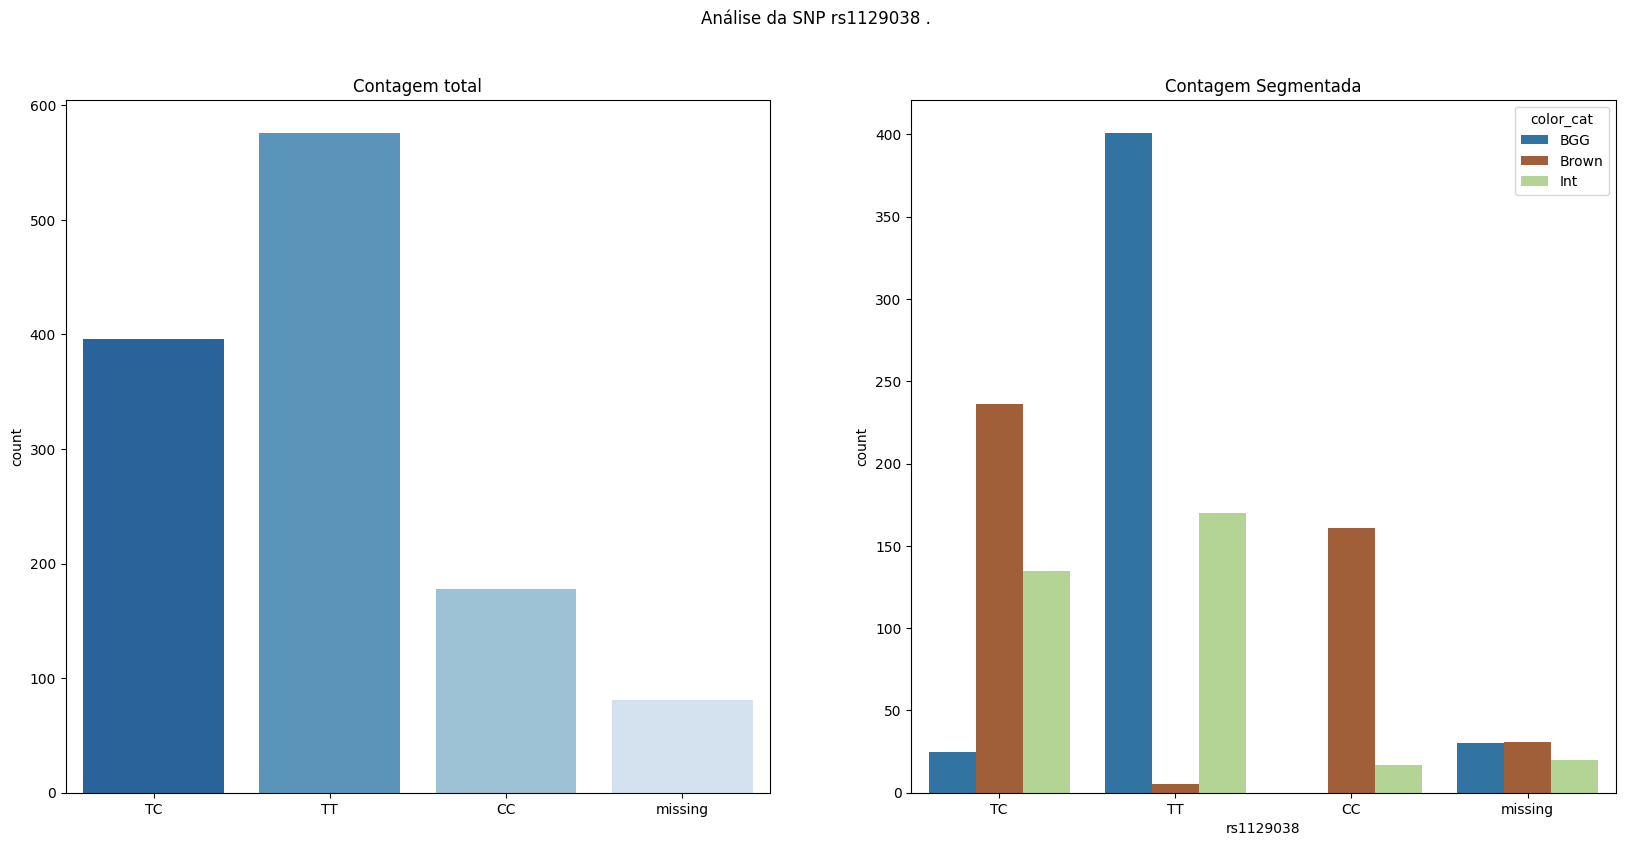

None

2 rs11636232


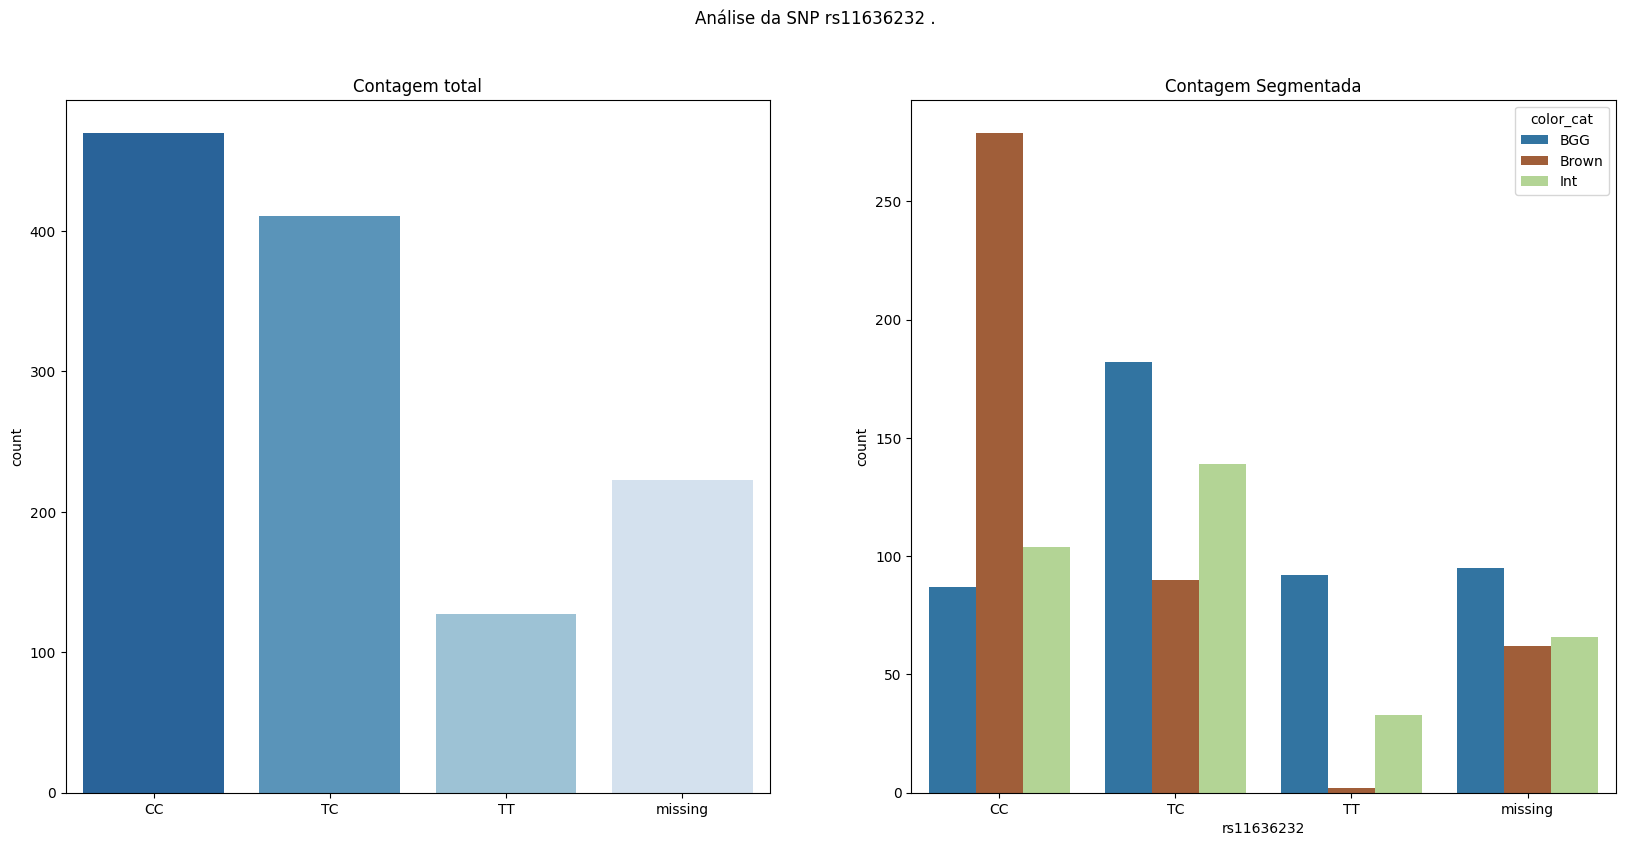

None

3 rs12203592


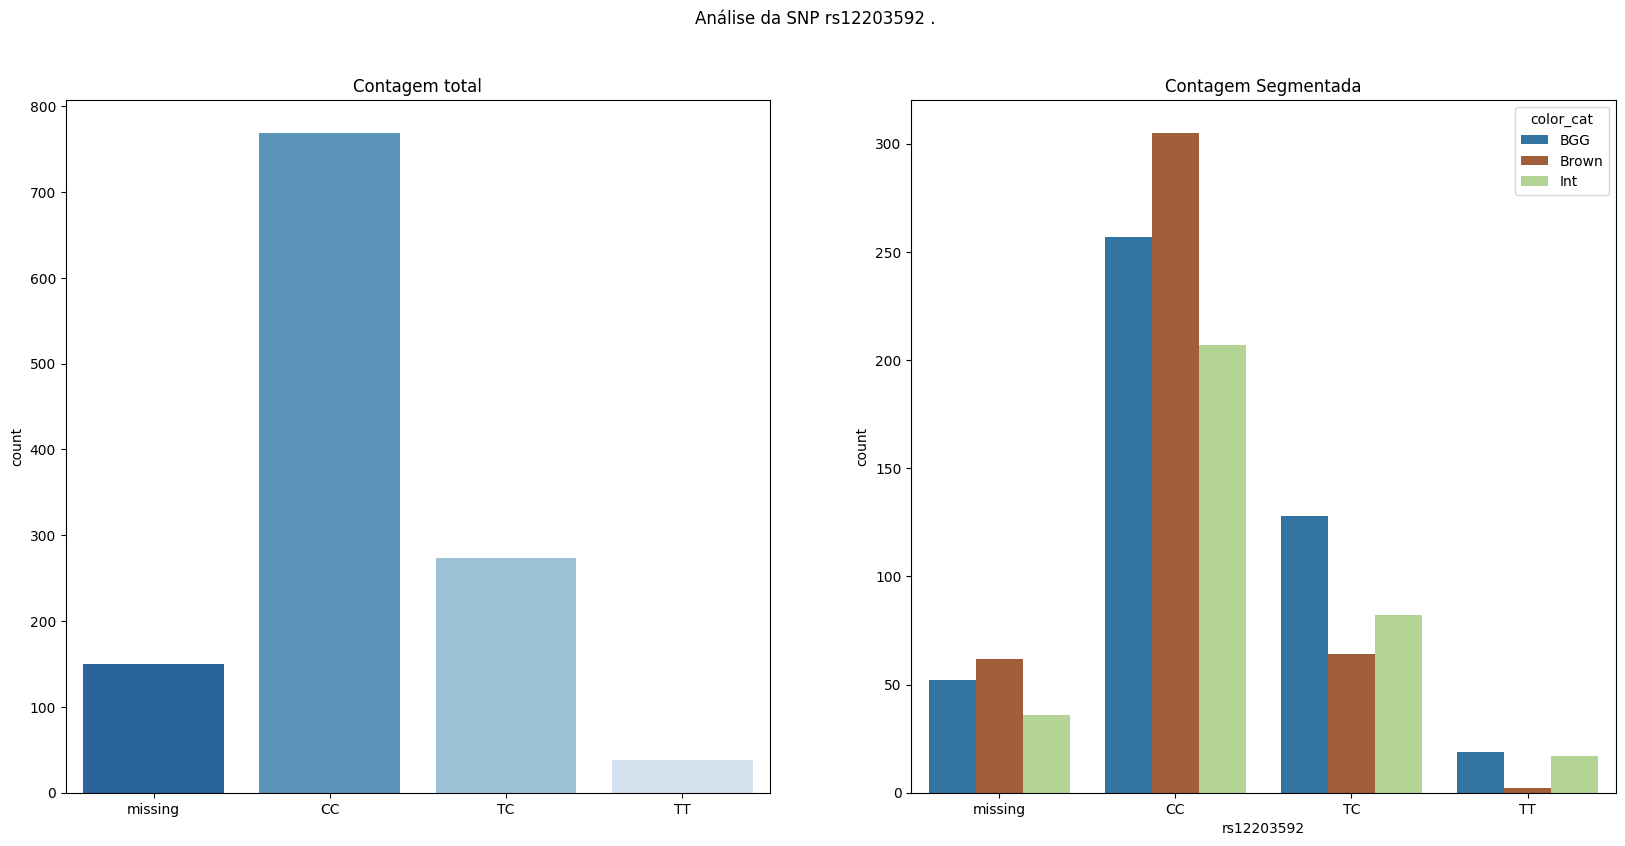

None

4 rs12896399


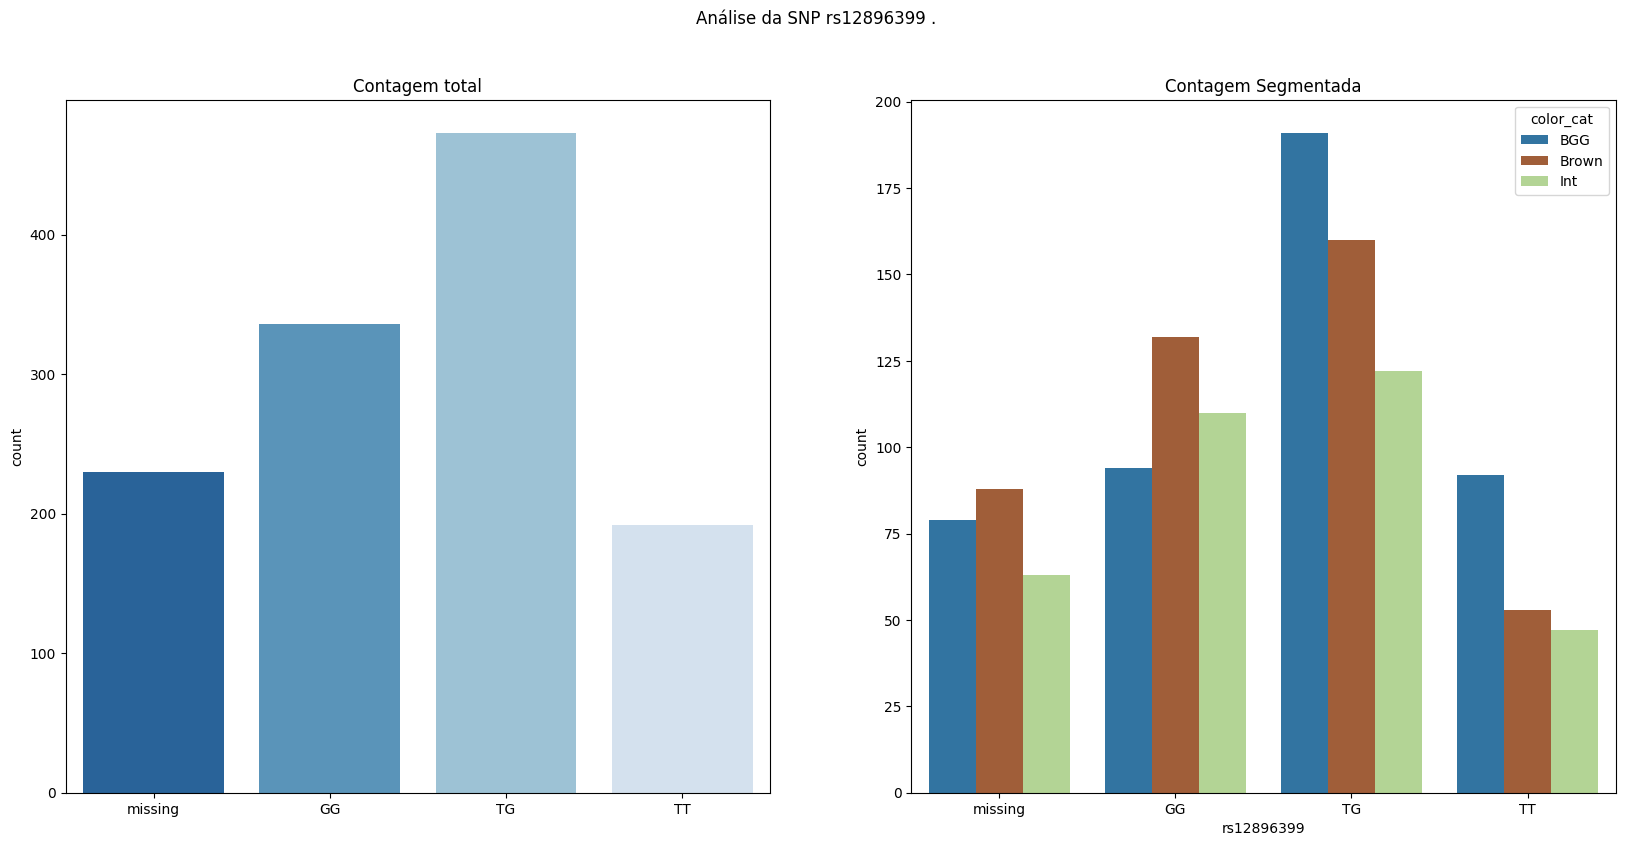

None

5 rs12913832


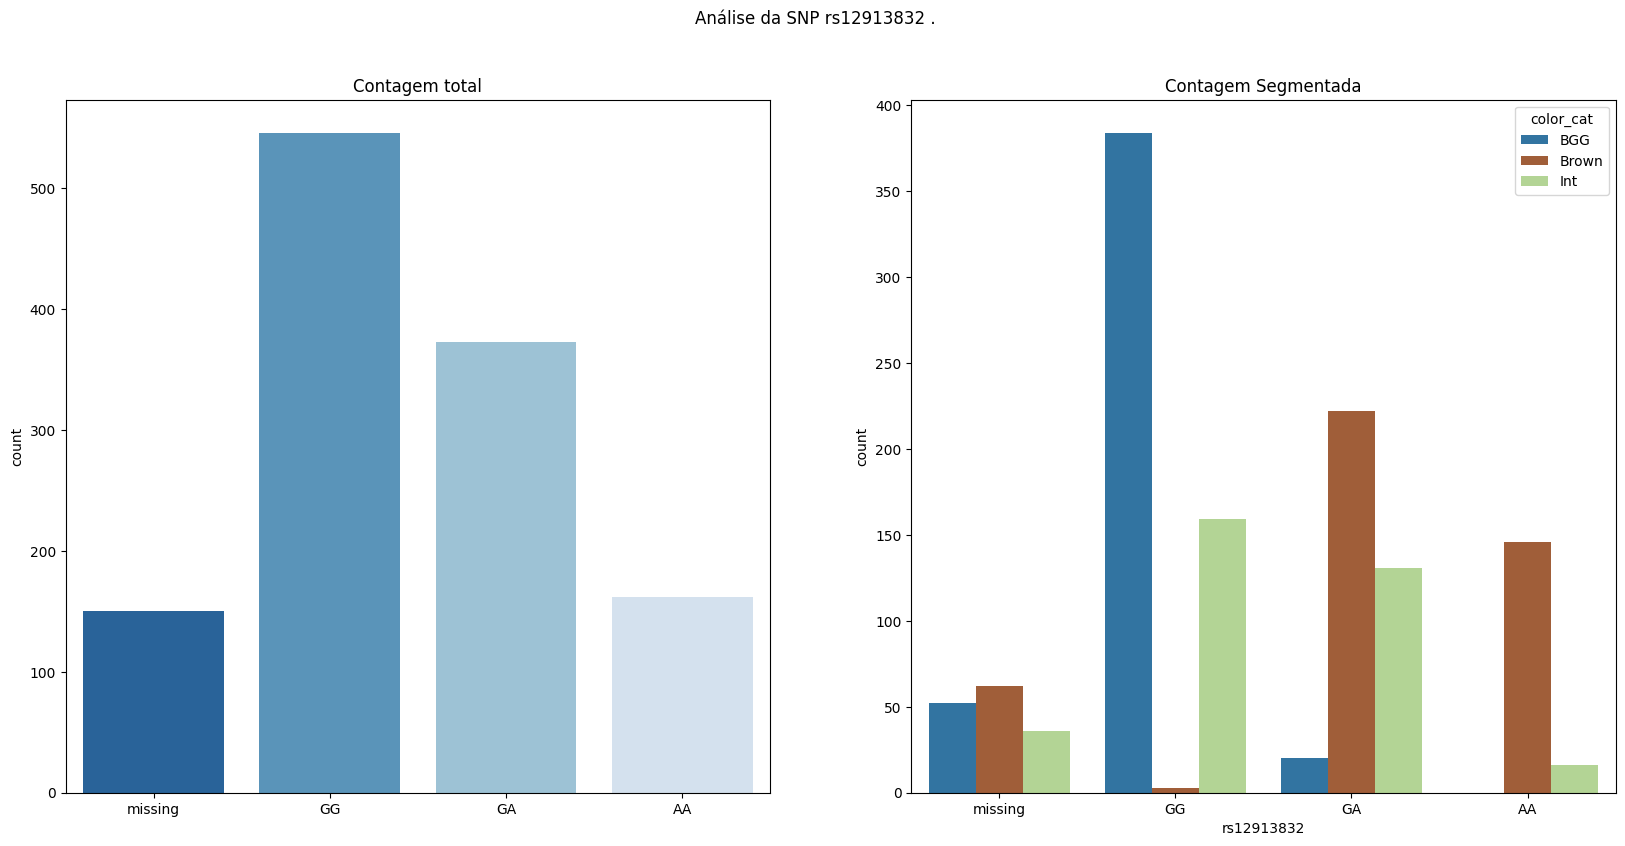

None

6 rs1393350


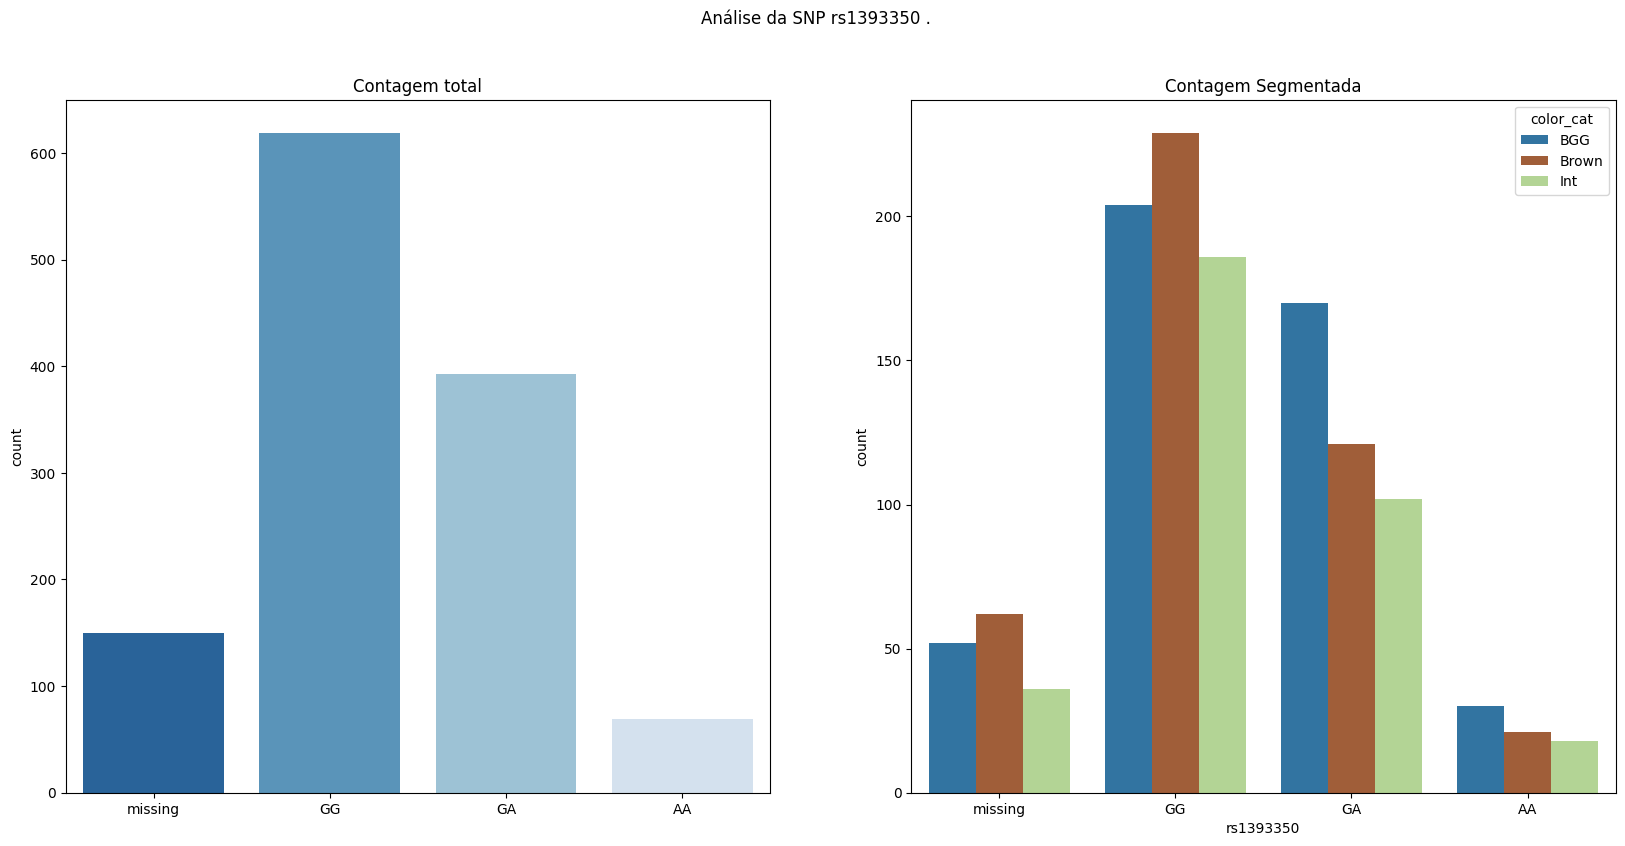

None

7 rs1667394


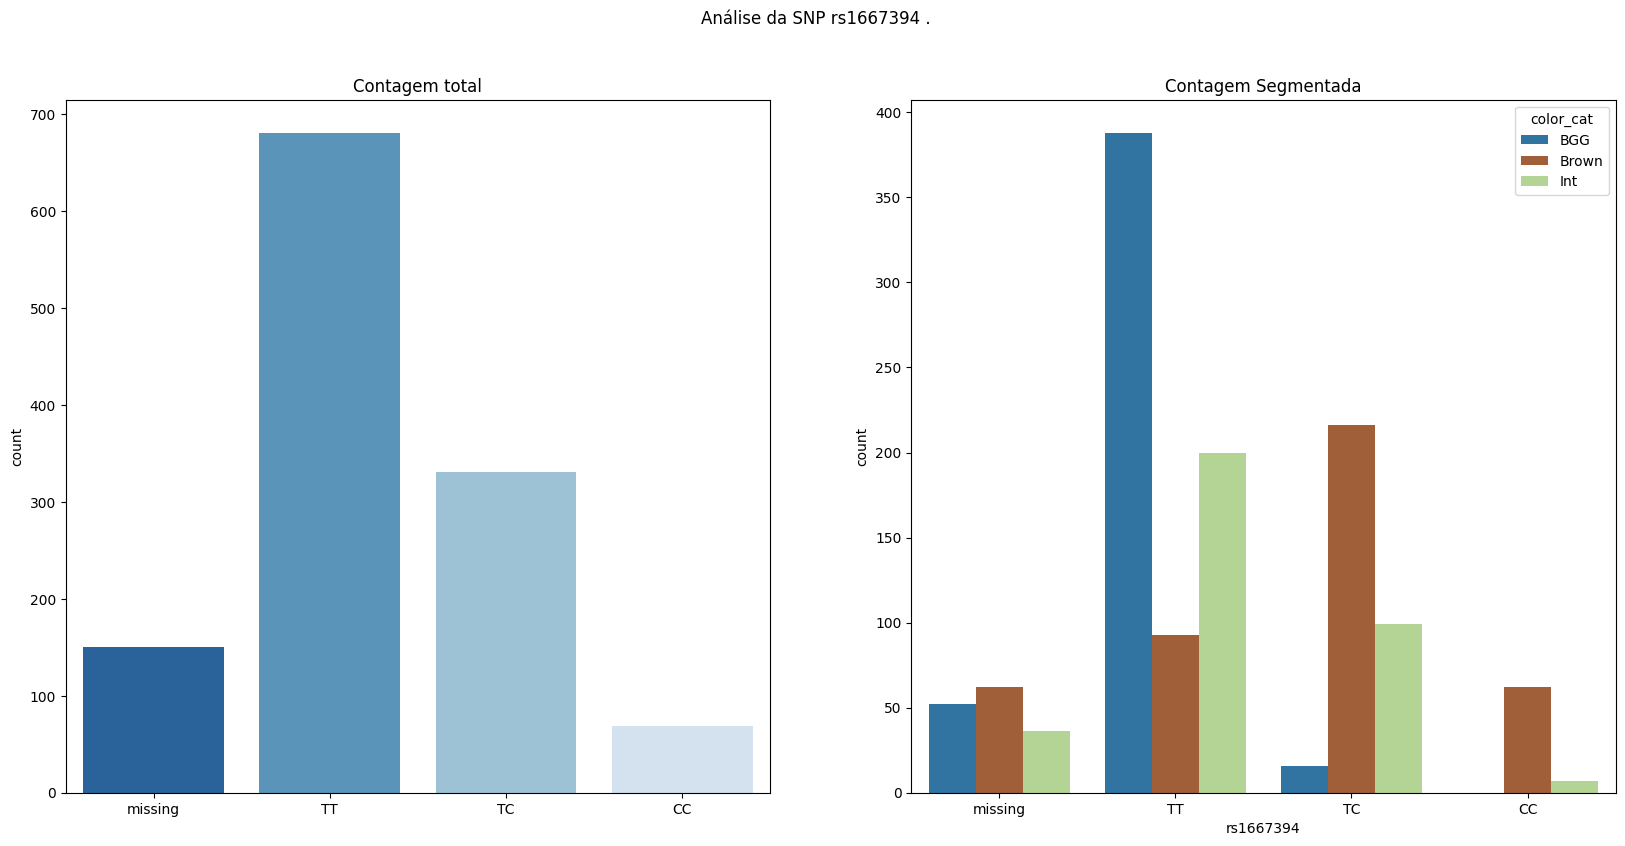

None

8 rs16891982


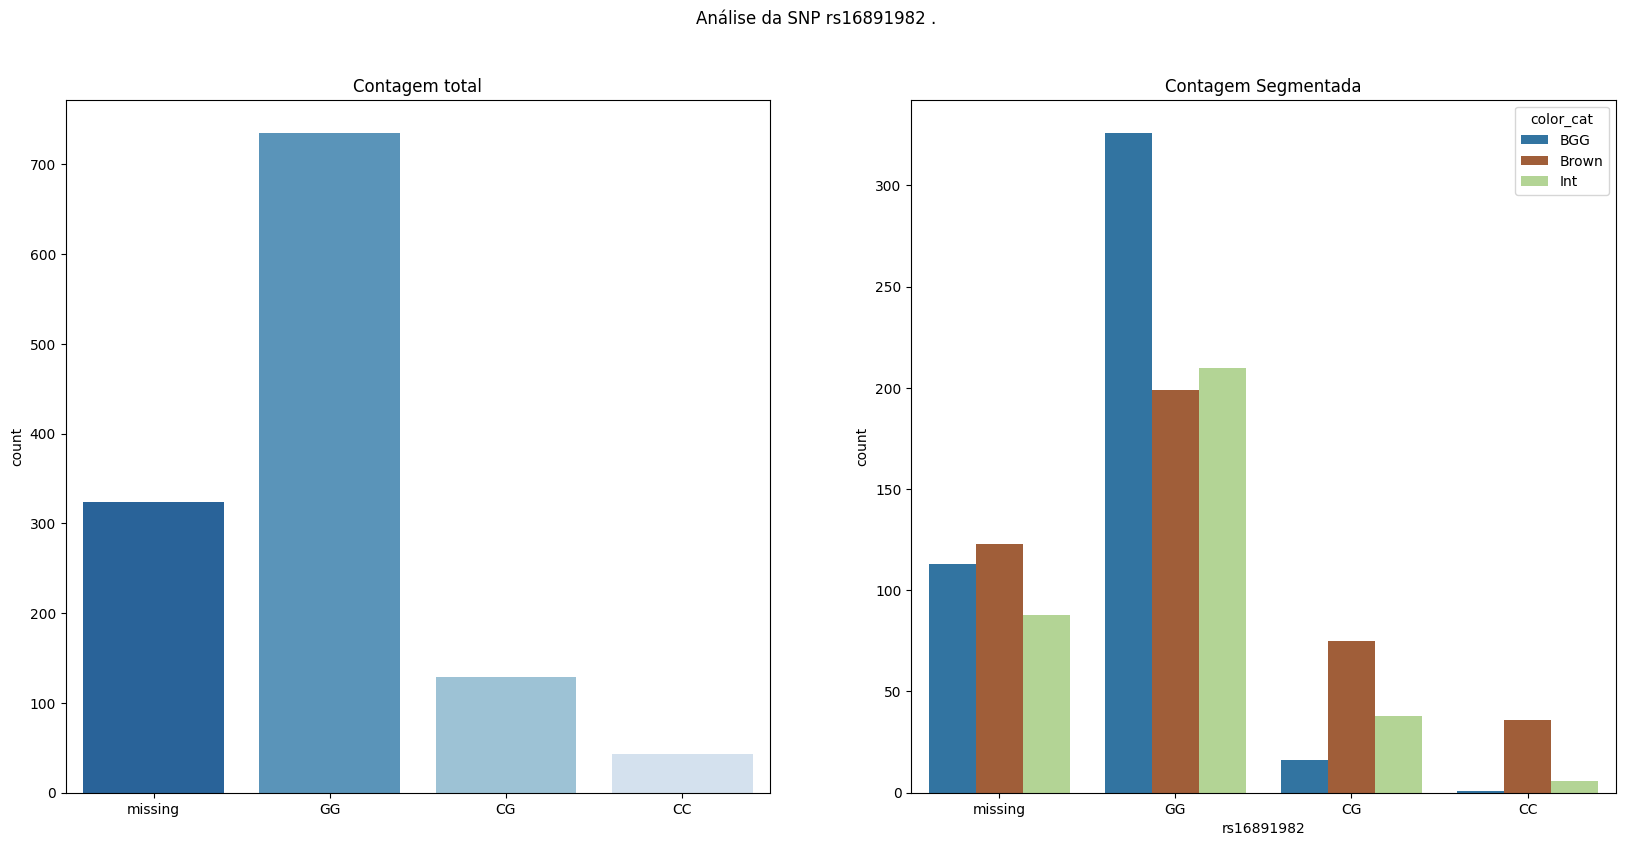

None

9 rs1800407


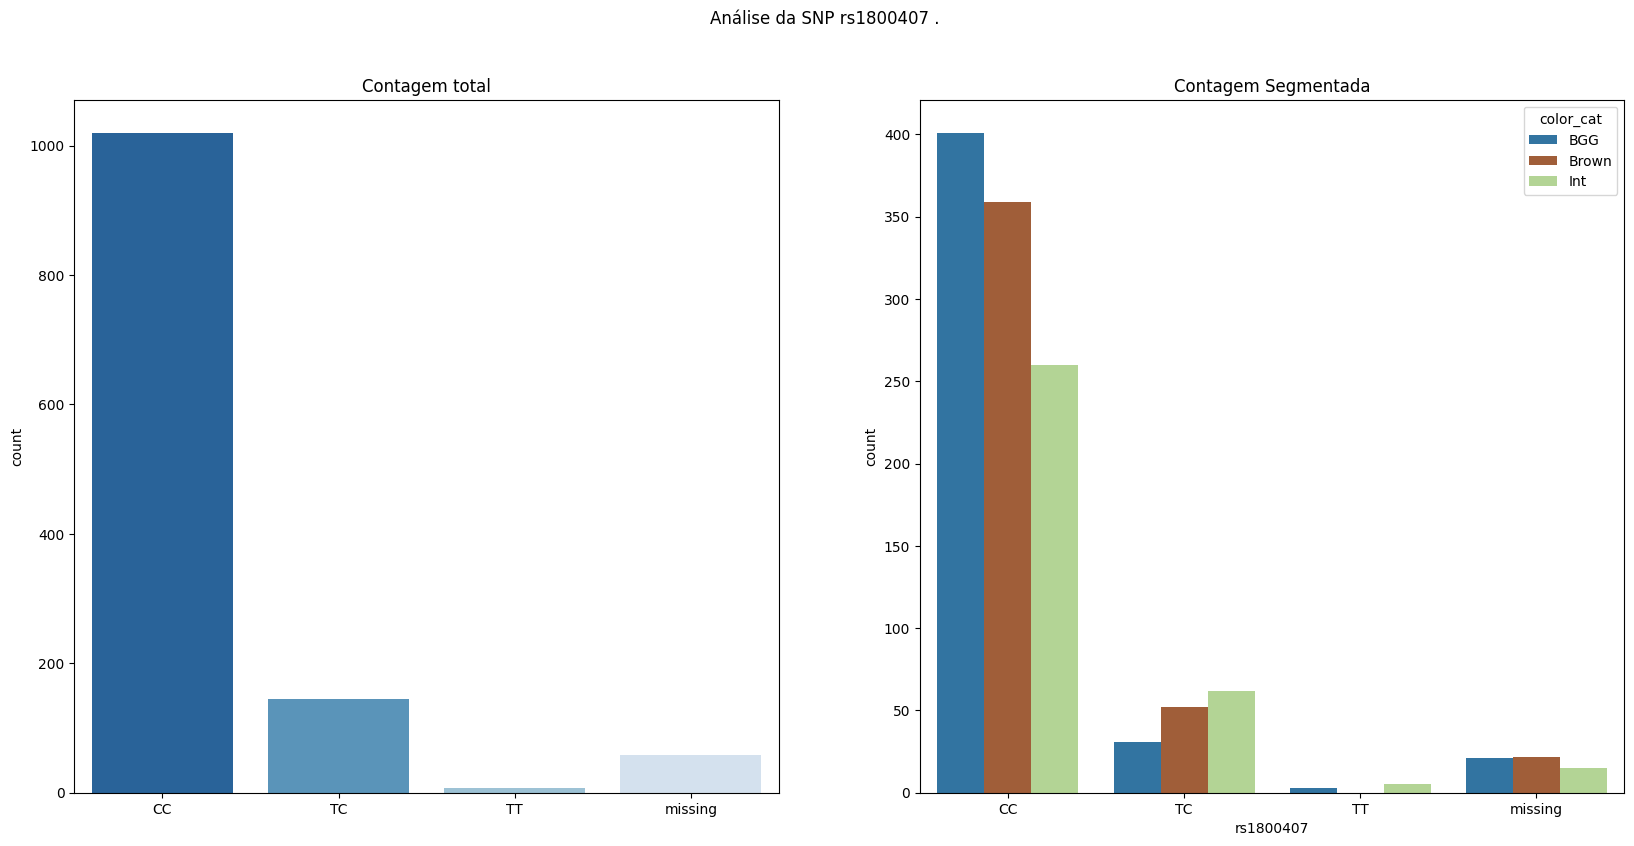

None

10 rs4778232


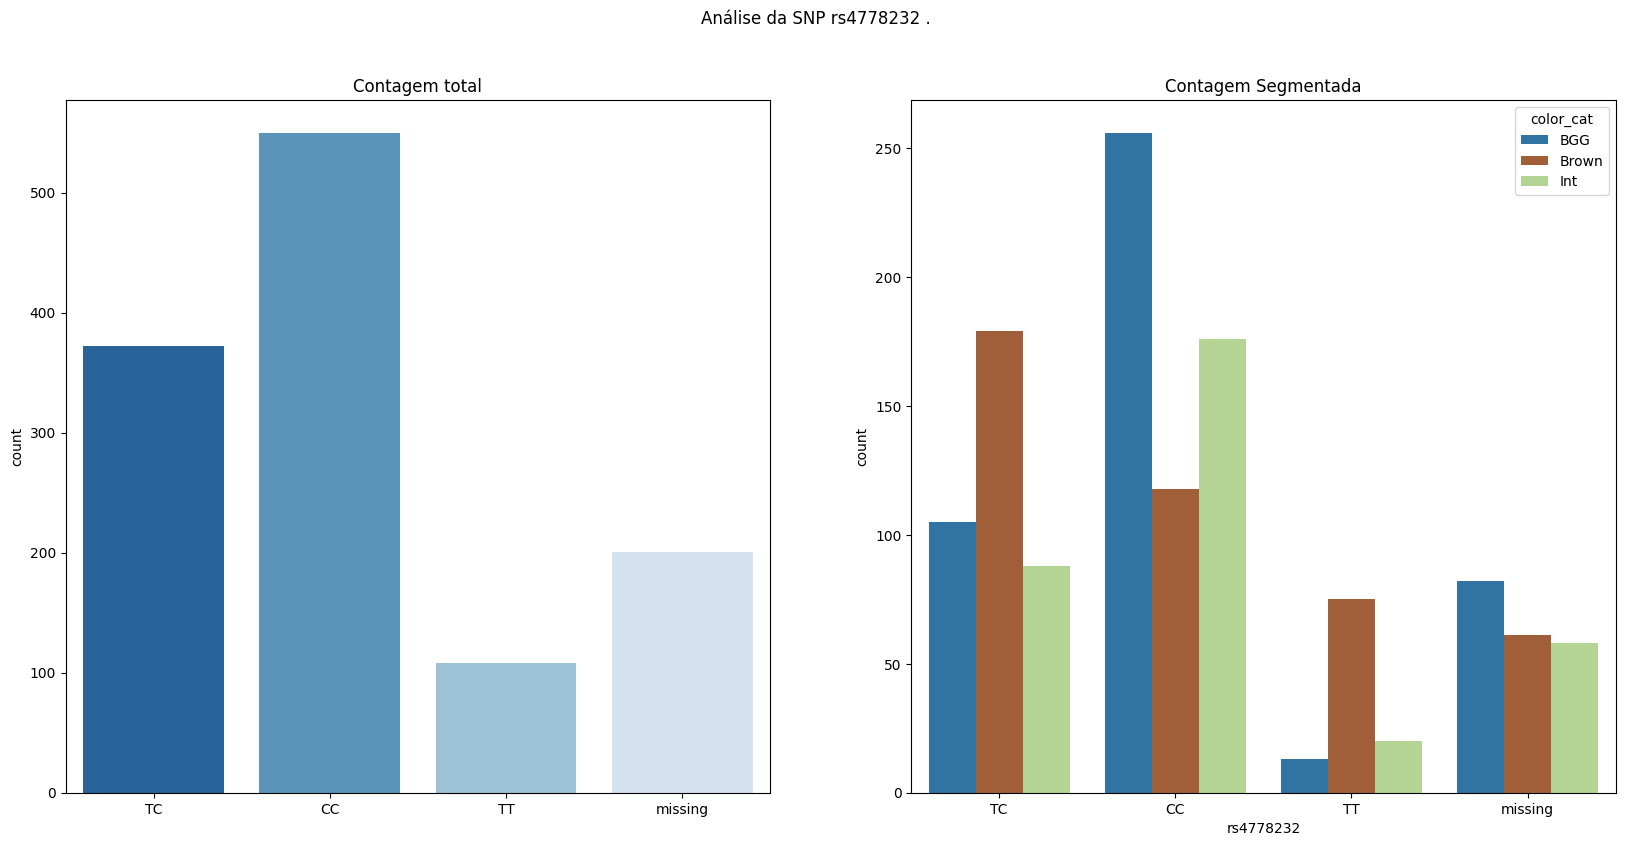

None

11 rs4778241


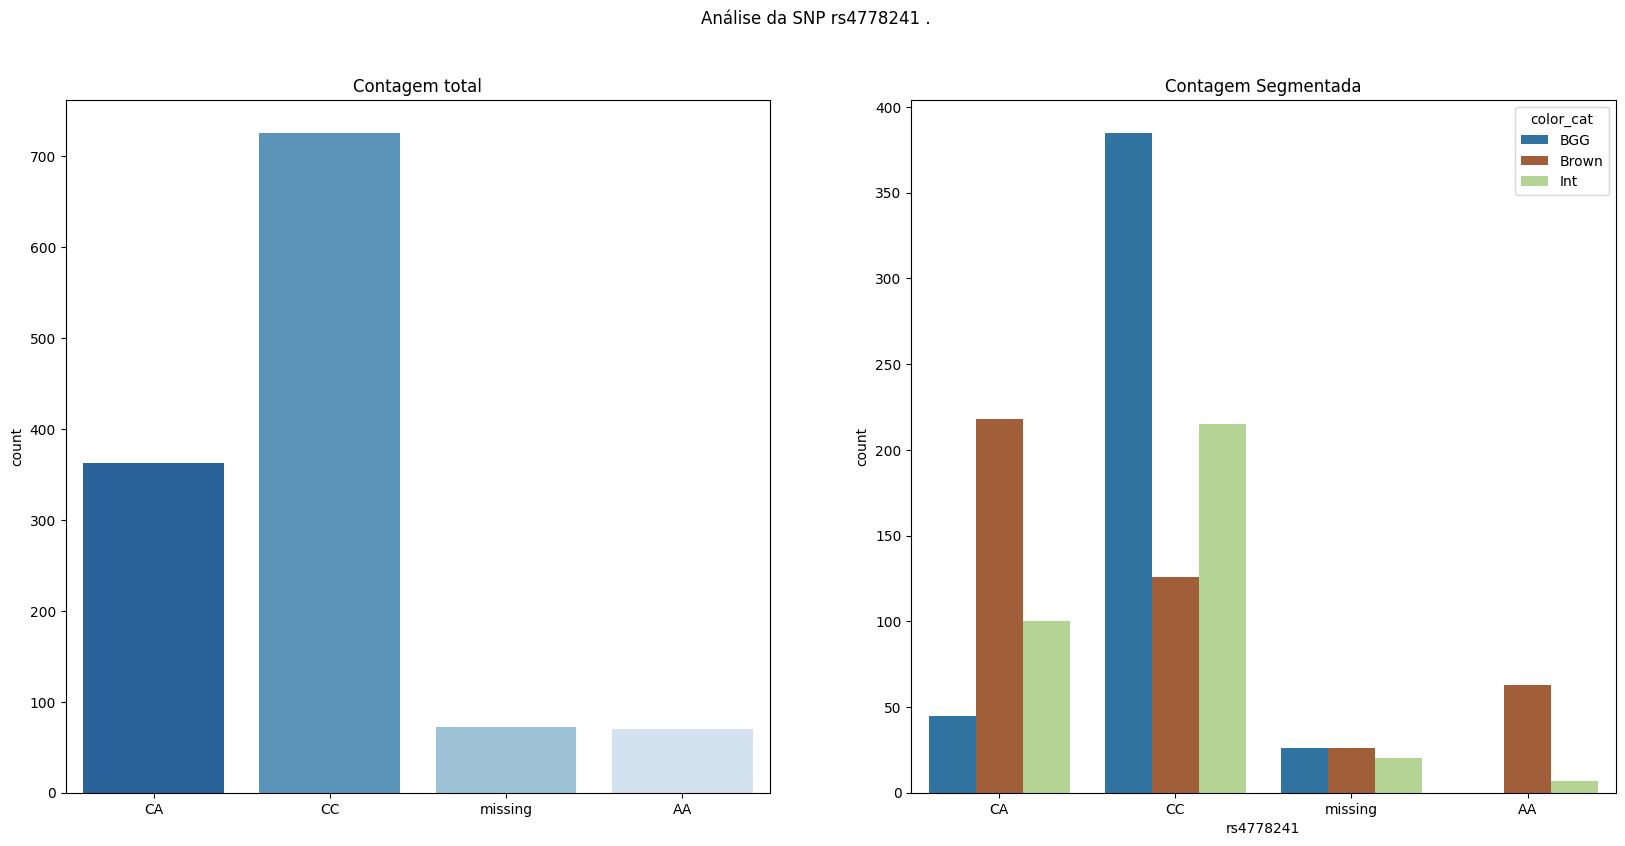

None

12 rs7183877


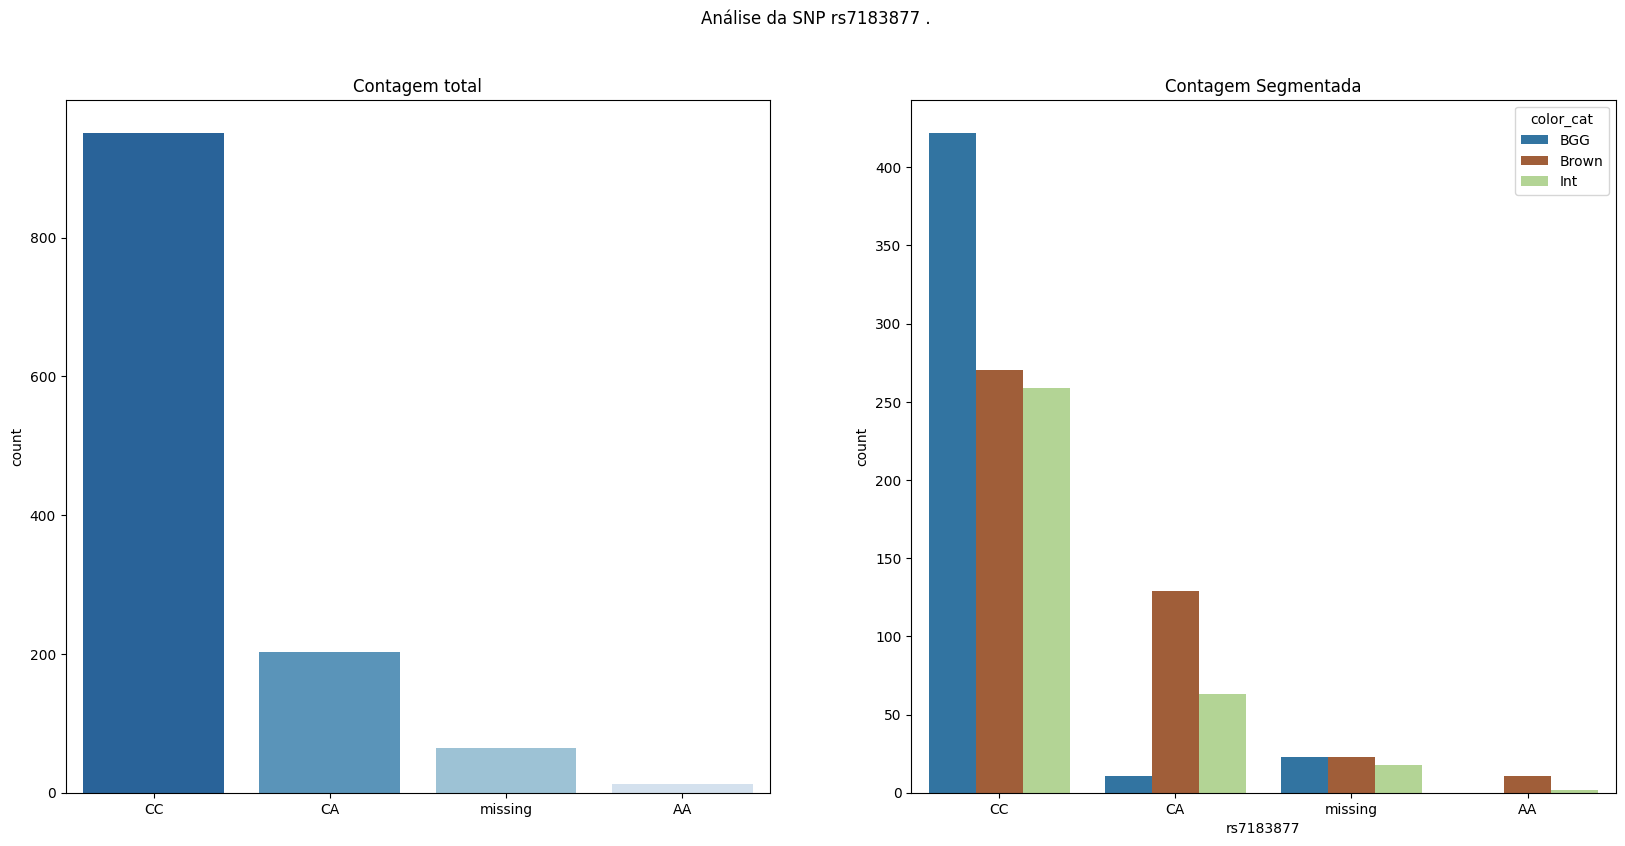

None

13 rs8024968


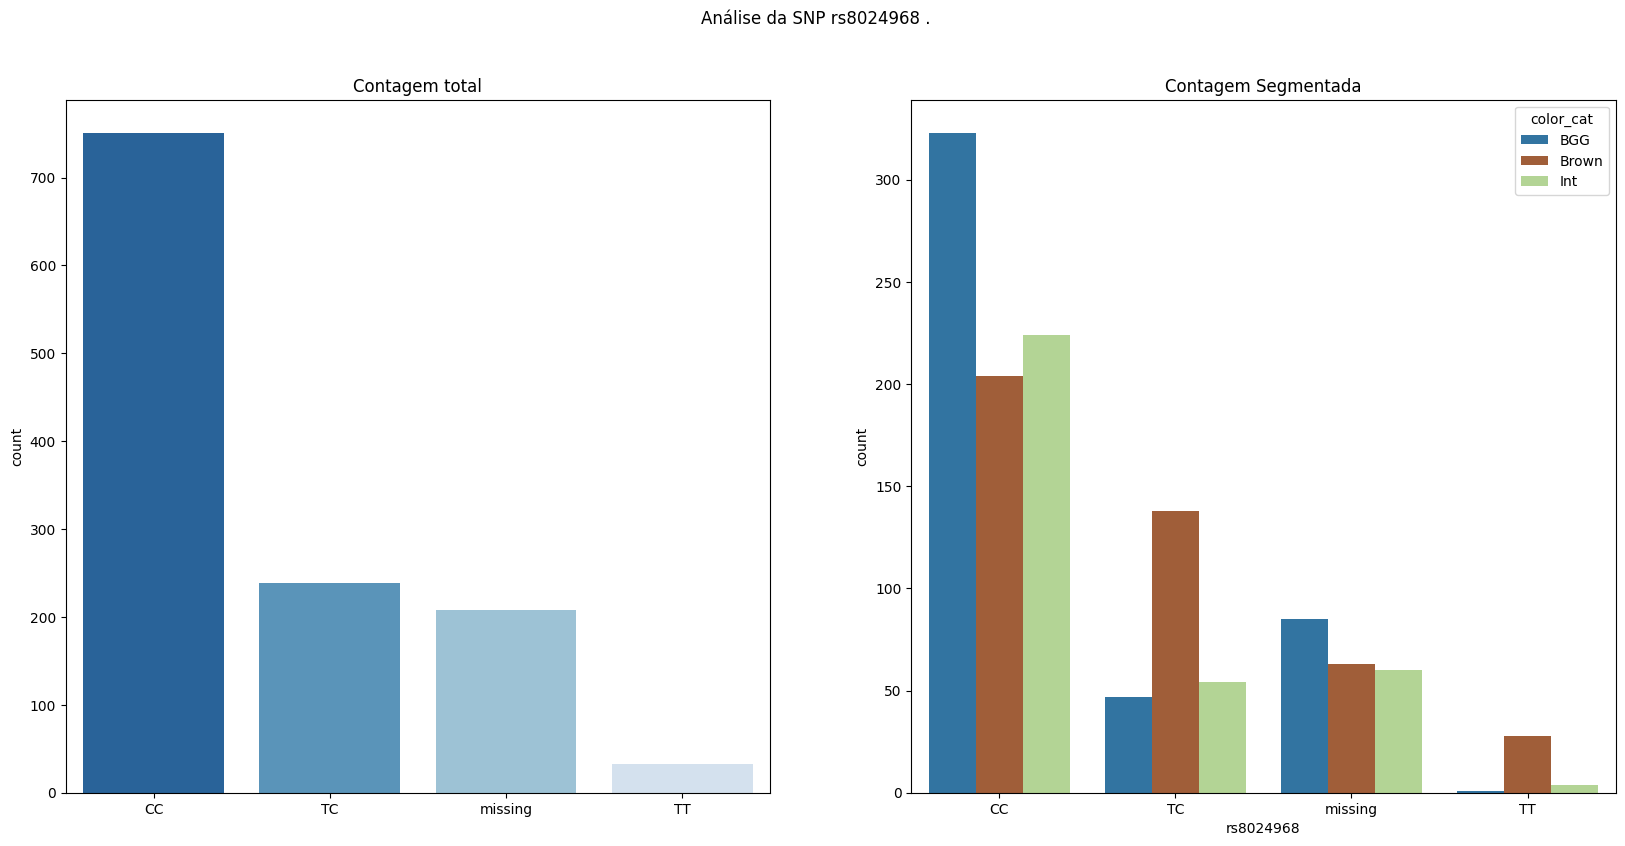

None

In [256]:
cont = 1
for i in df.columns[:-1]:
    print(cont, i)
    display(plot_contagem(i))
    cont+=1

snp_list[:-3]

for snp in snp_list[:-3]:
    
    df_grouped = df.groupby("color_cat")[snp].value_counts().unstack()
    df_grouped = df_grouped.apply(lambda x: round(x/x.sum(), 2) * 100)
    display(df_grouped)

## Análise da proporções das categorias para cada coluna

1 rs1129038
2 rs11636232
3 rs12203592
4 rs12896399
5 rs12913832
6 rs1393350
7 rs1667394
8 rs16891982
9 rs1800407
10 rs4778232
11 rs4778241
12 rs7183877
13 rs8024968


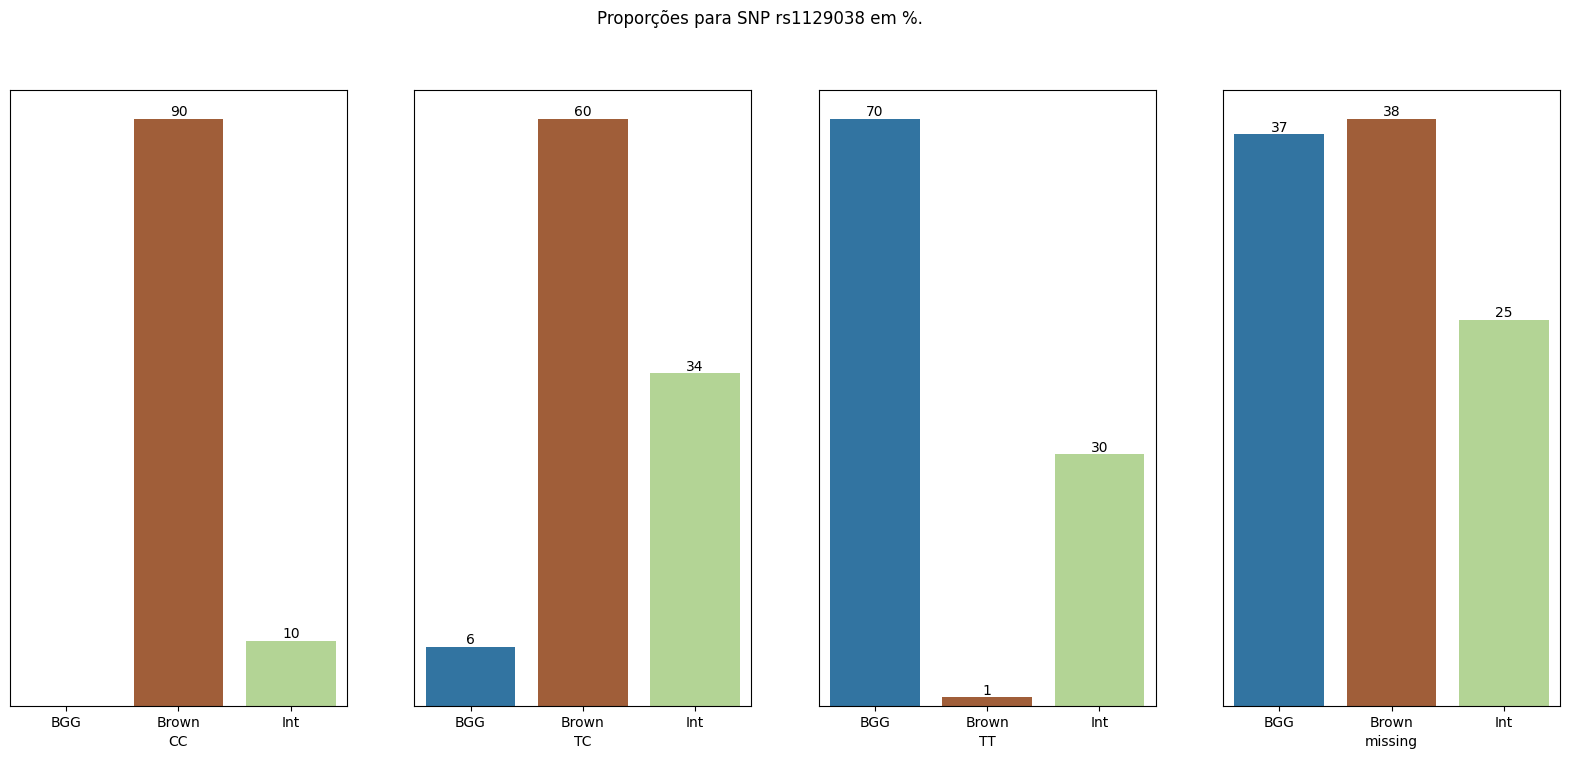

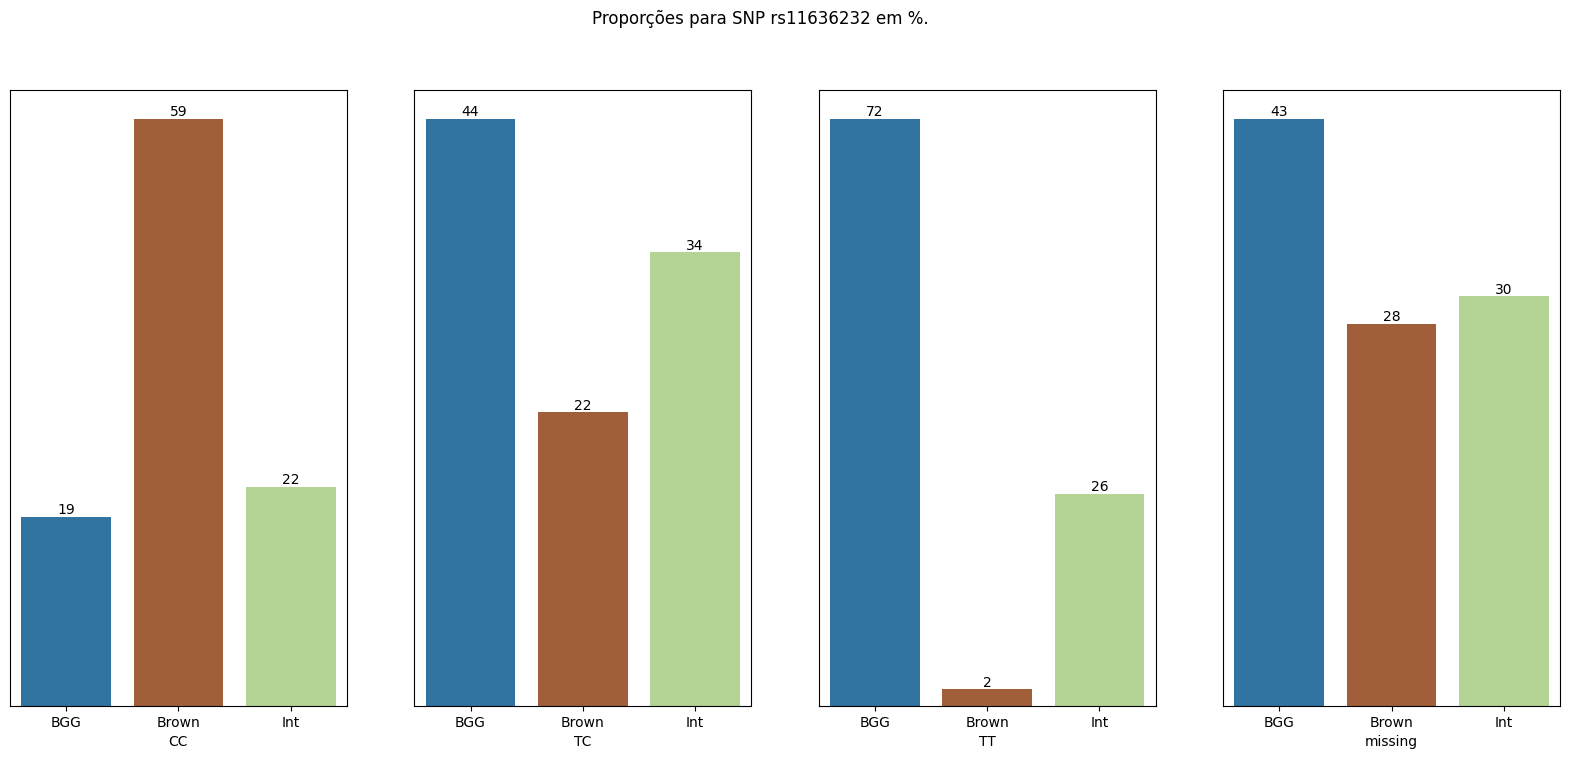

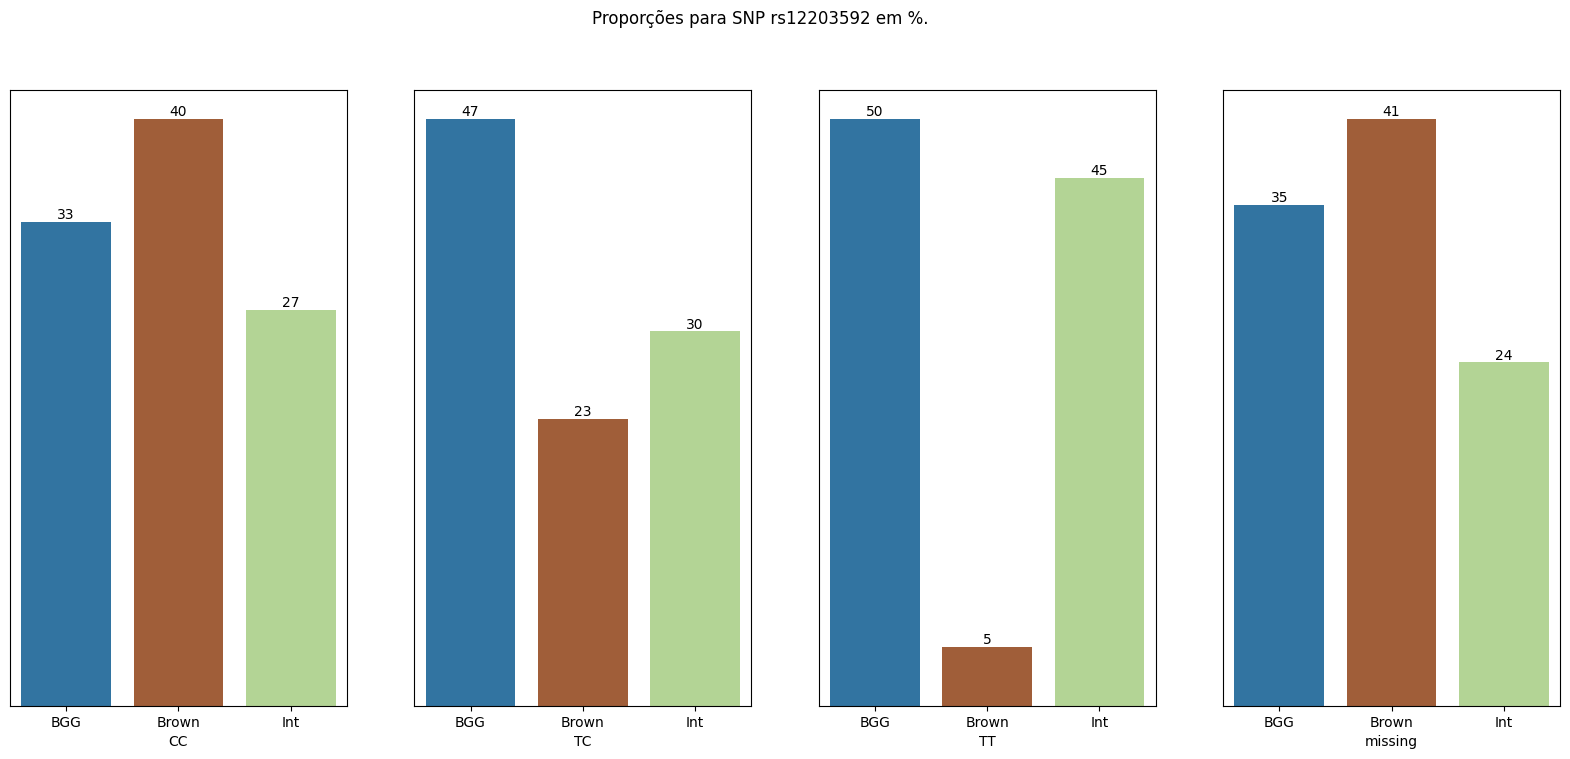

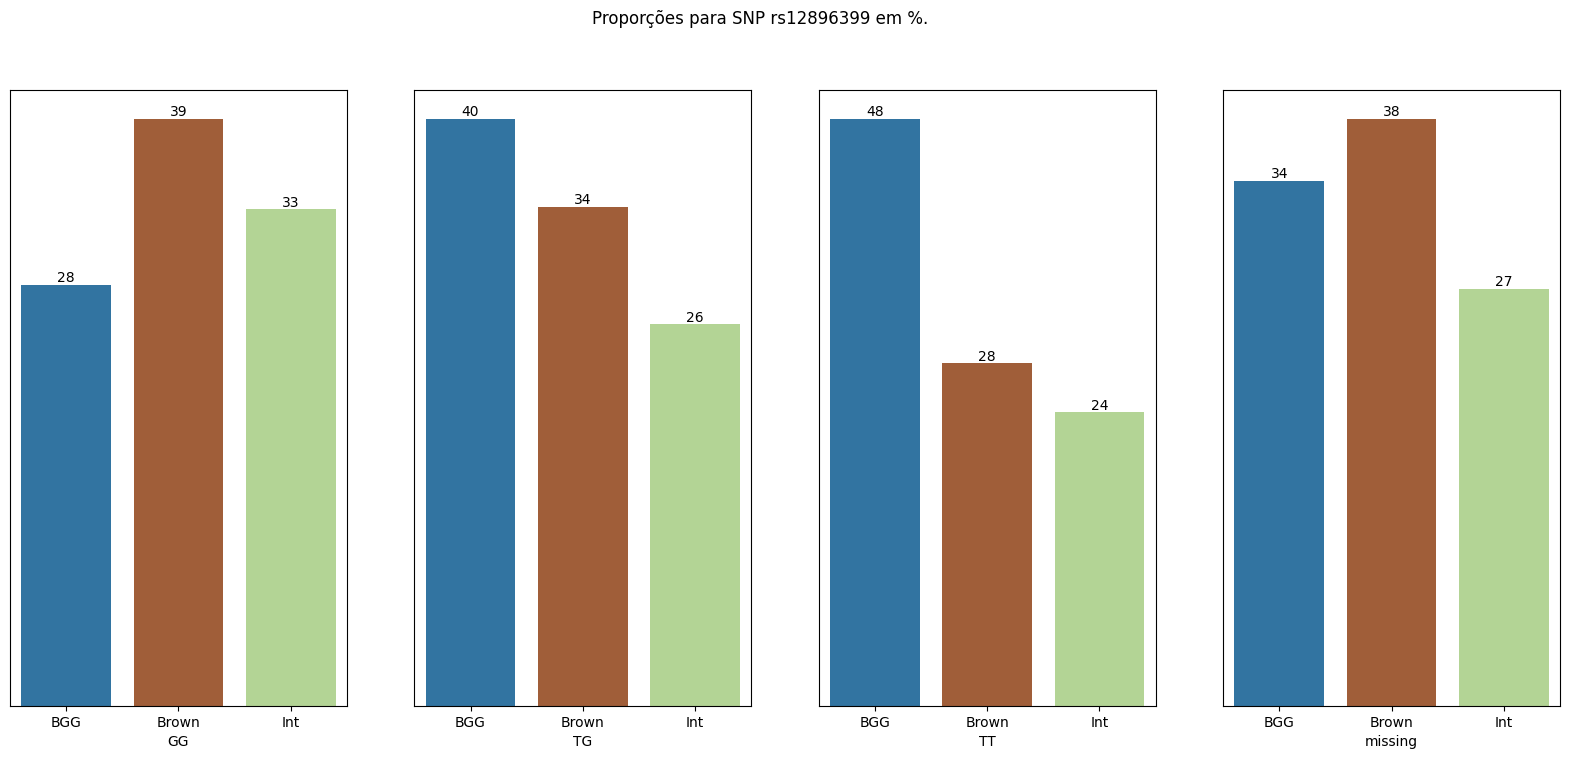

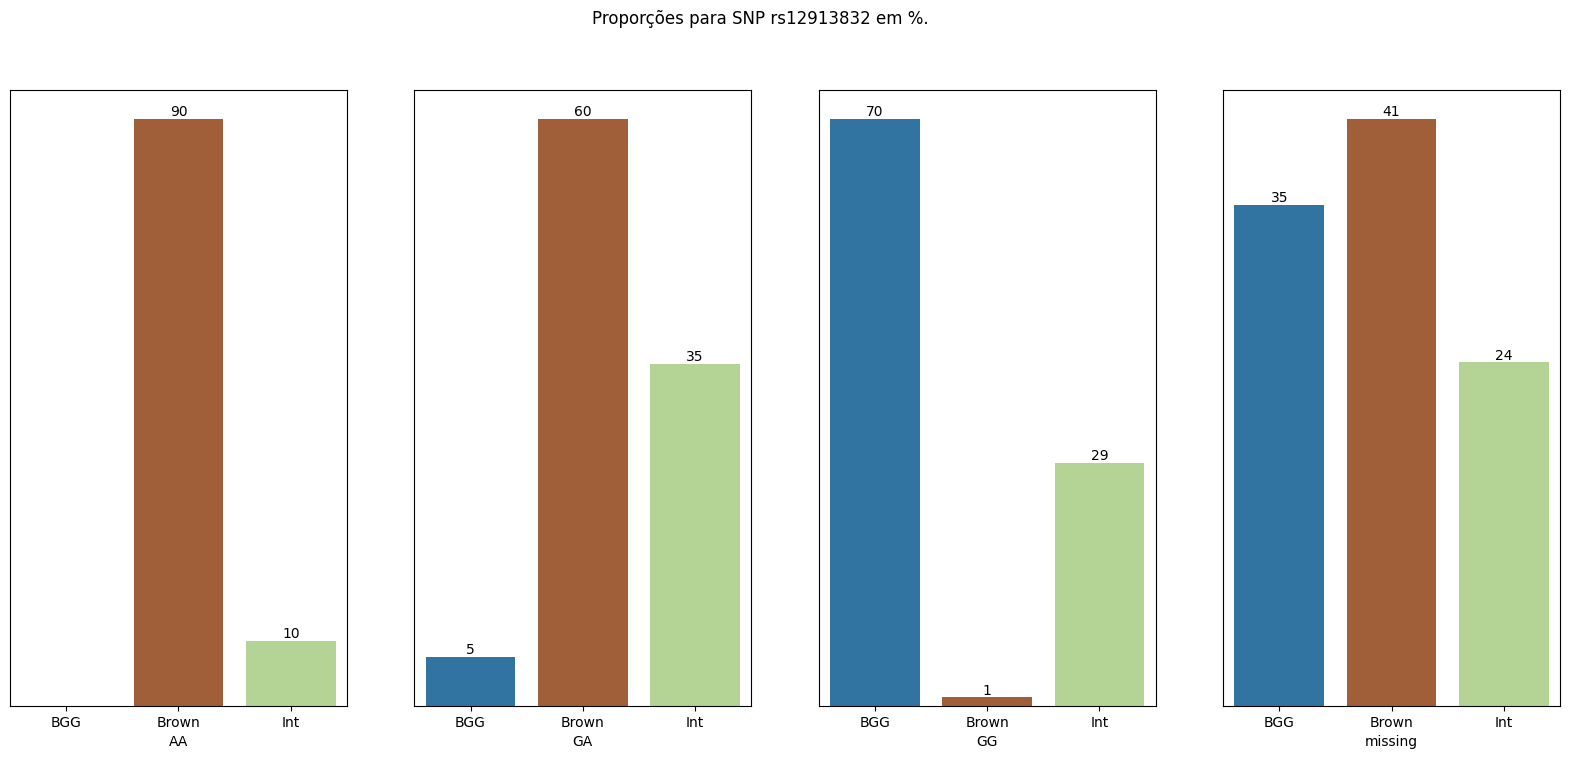

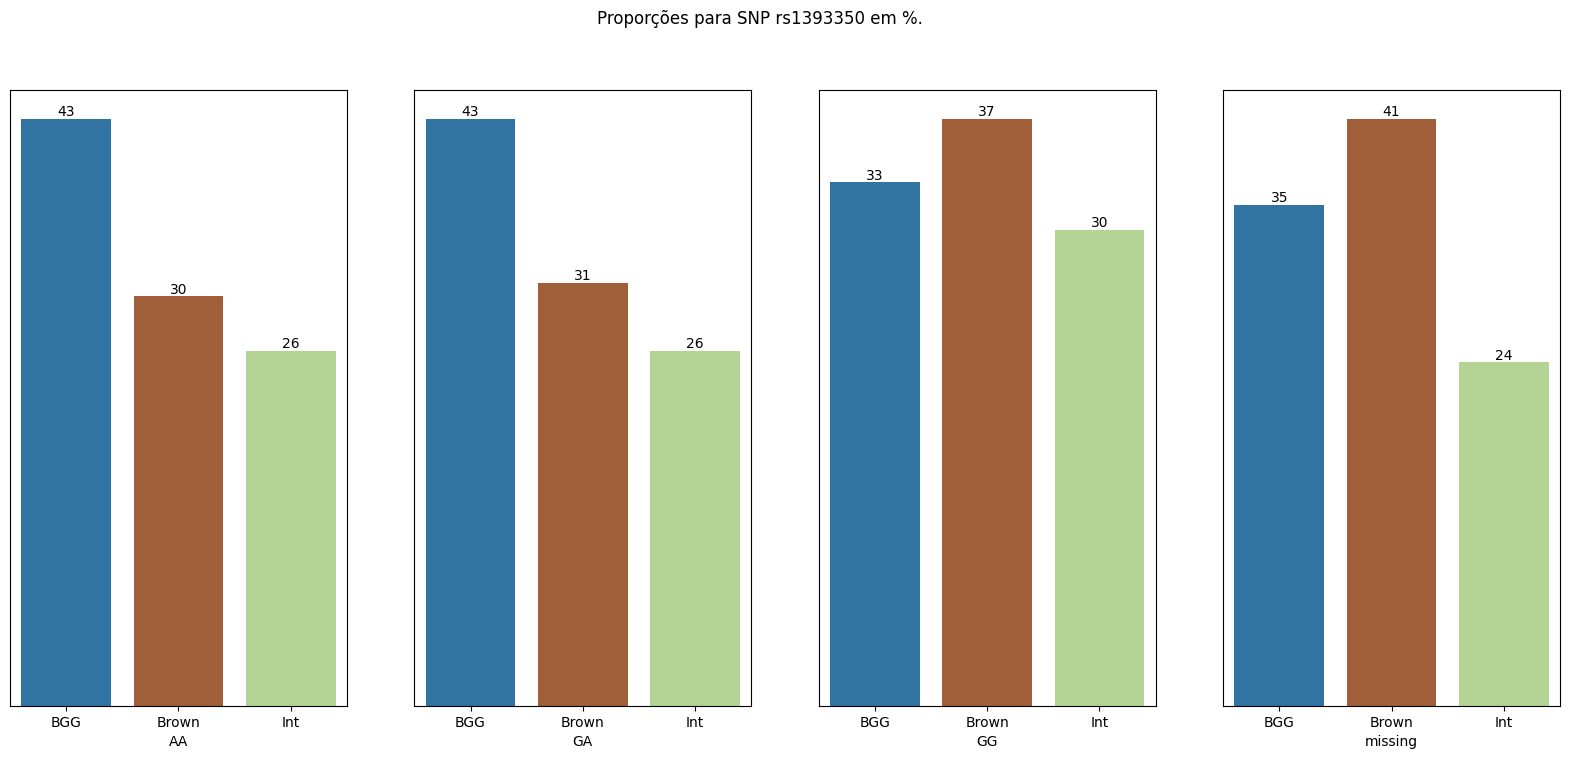

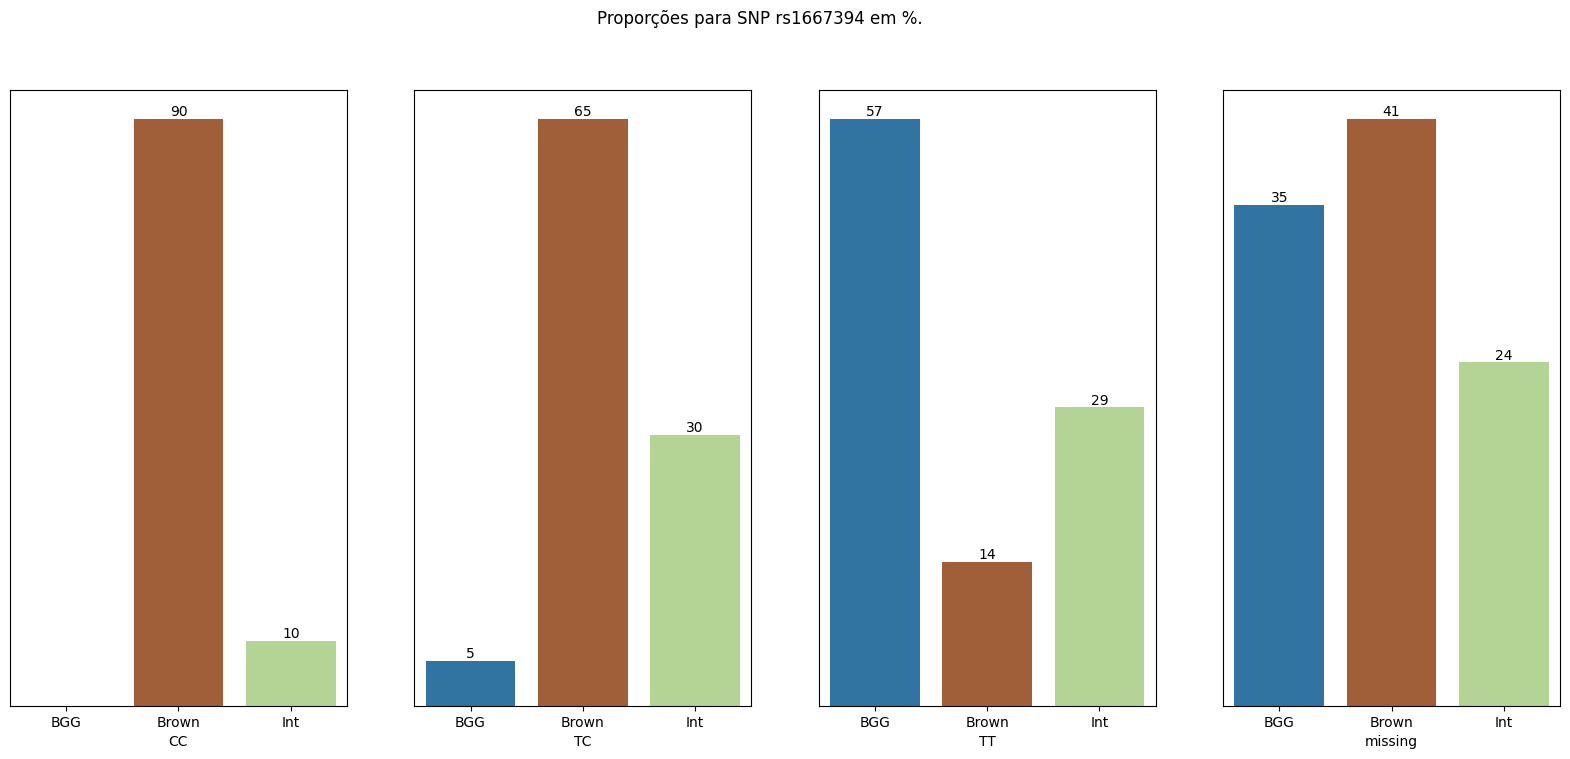

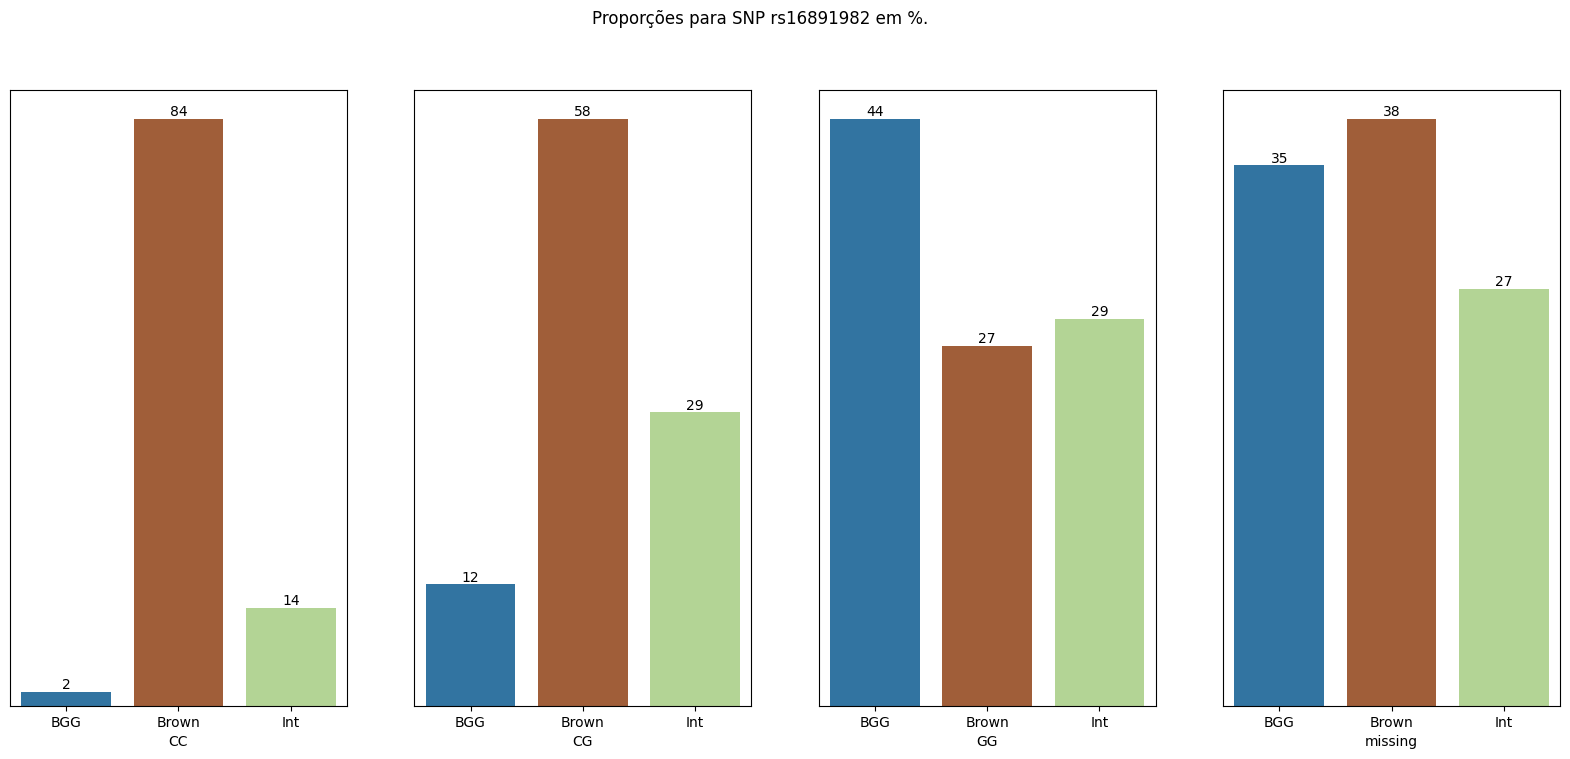

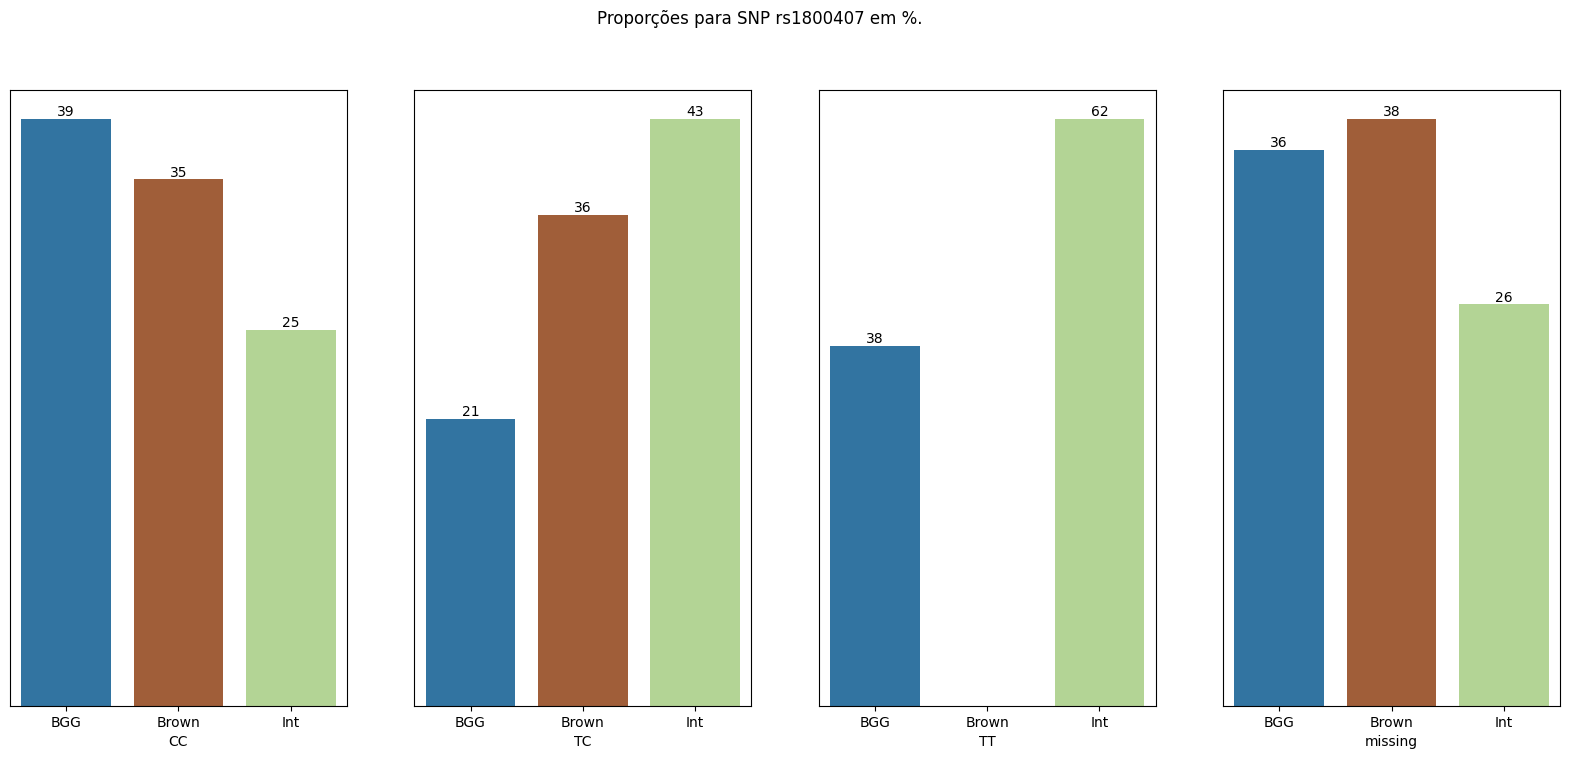

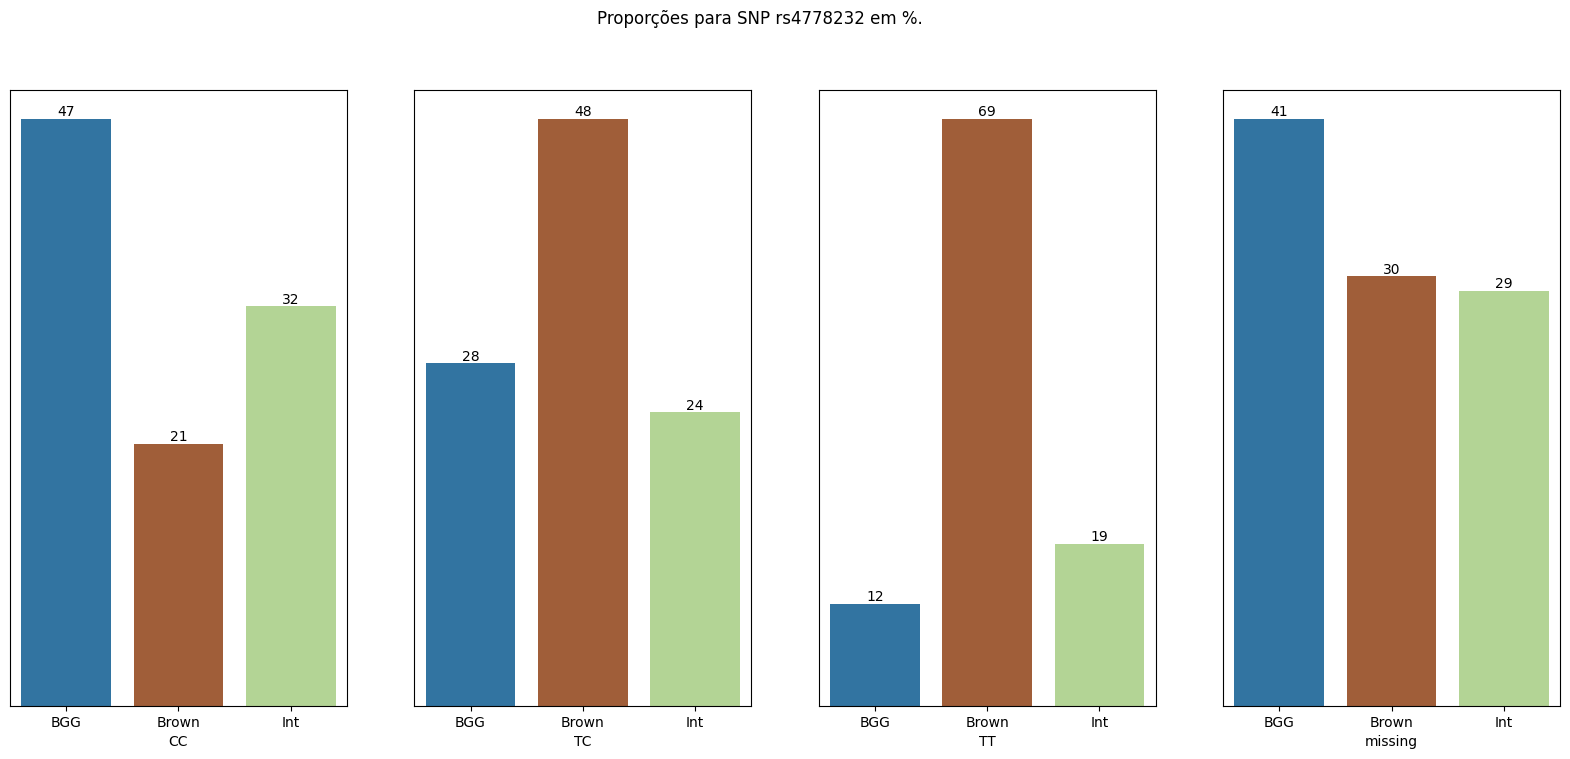

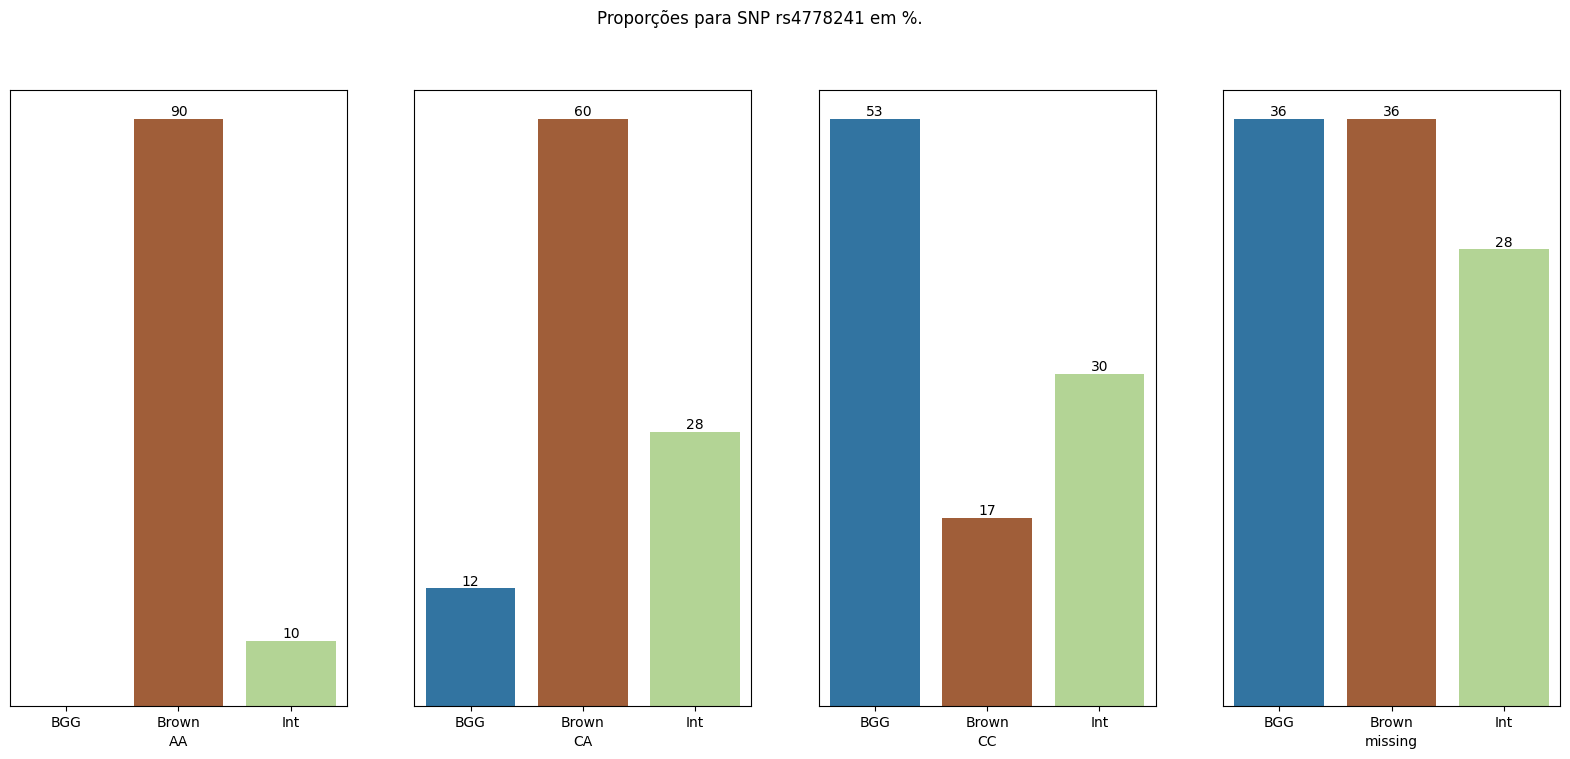

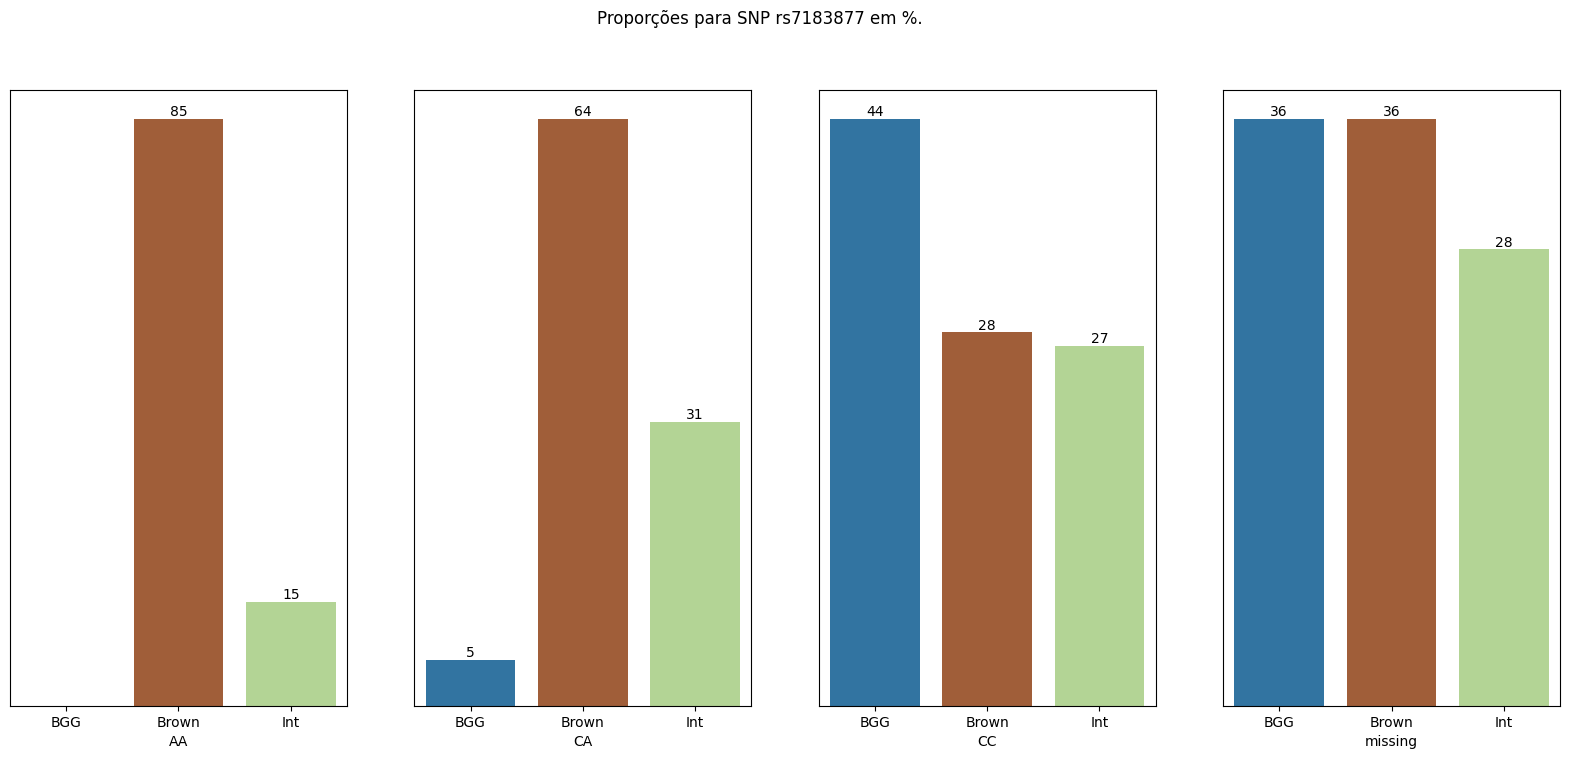

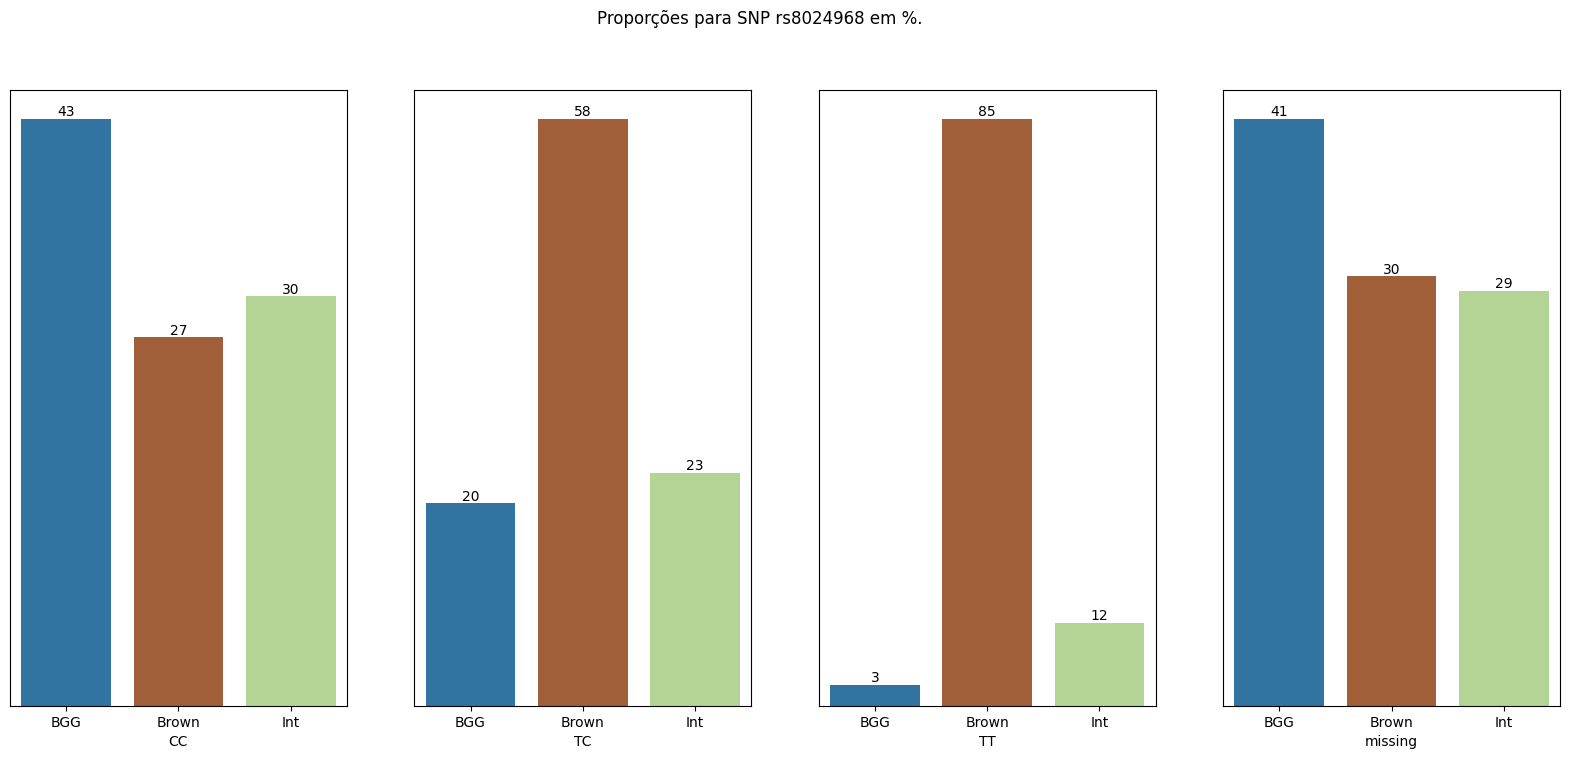

In [259]:
cont = 1
for snp in snp_list_13:
    
    df_grouped = df.groupby("color_cat")[snp].value_counts().unstack()
    df_grouped = df_grouped.apply(lambda x: round(x/x.sum(), 2) * 100)
    df_grouped
    
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,8))
    fig.suptitle(f"Proporções para SNP {snp} em %.")
    print(cont, snp)
    cont+=1
    #fig.axes.get_yaxis().set_visible(False)

    colors = ['#1f78b4', '#b15928', '#b2df8a']
    for i in range(len(df_grouped.columns)):
        y = df_grouped.columns[i]
        sns.barplot(ax = ax[i], x = df_grouped.index, y=y, data = df_grouped, palette=colors)
        ax[i].set_xlabel(df_grouped.columns[i])
        ax[i].set_ylabel(" ")    
        ax[i].get_yaxis().set_visible(False)
        for j in ax[i].containers:
            ax[i].bar_label(j,)

## One Hot Encoding para explorar correlações

In [232]:
df_num = pd.get_dummies(df)

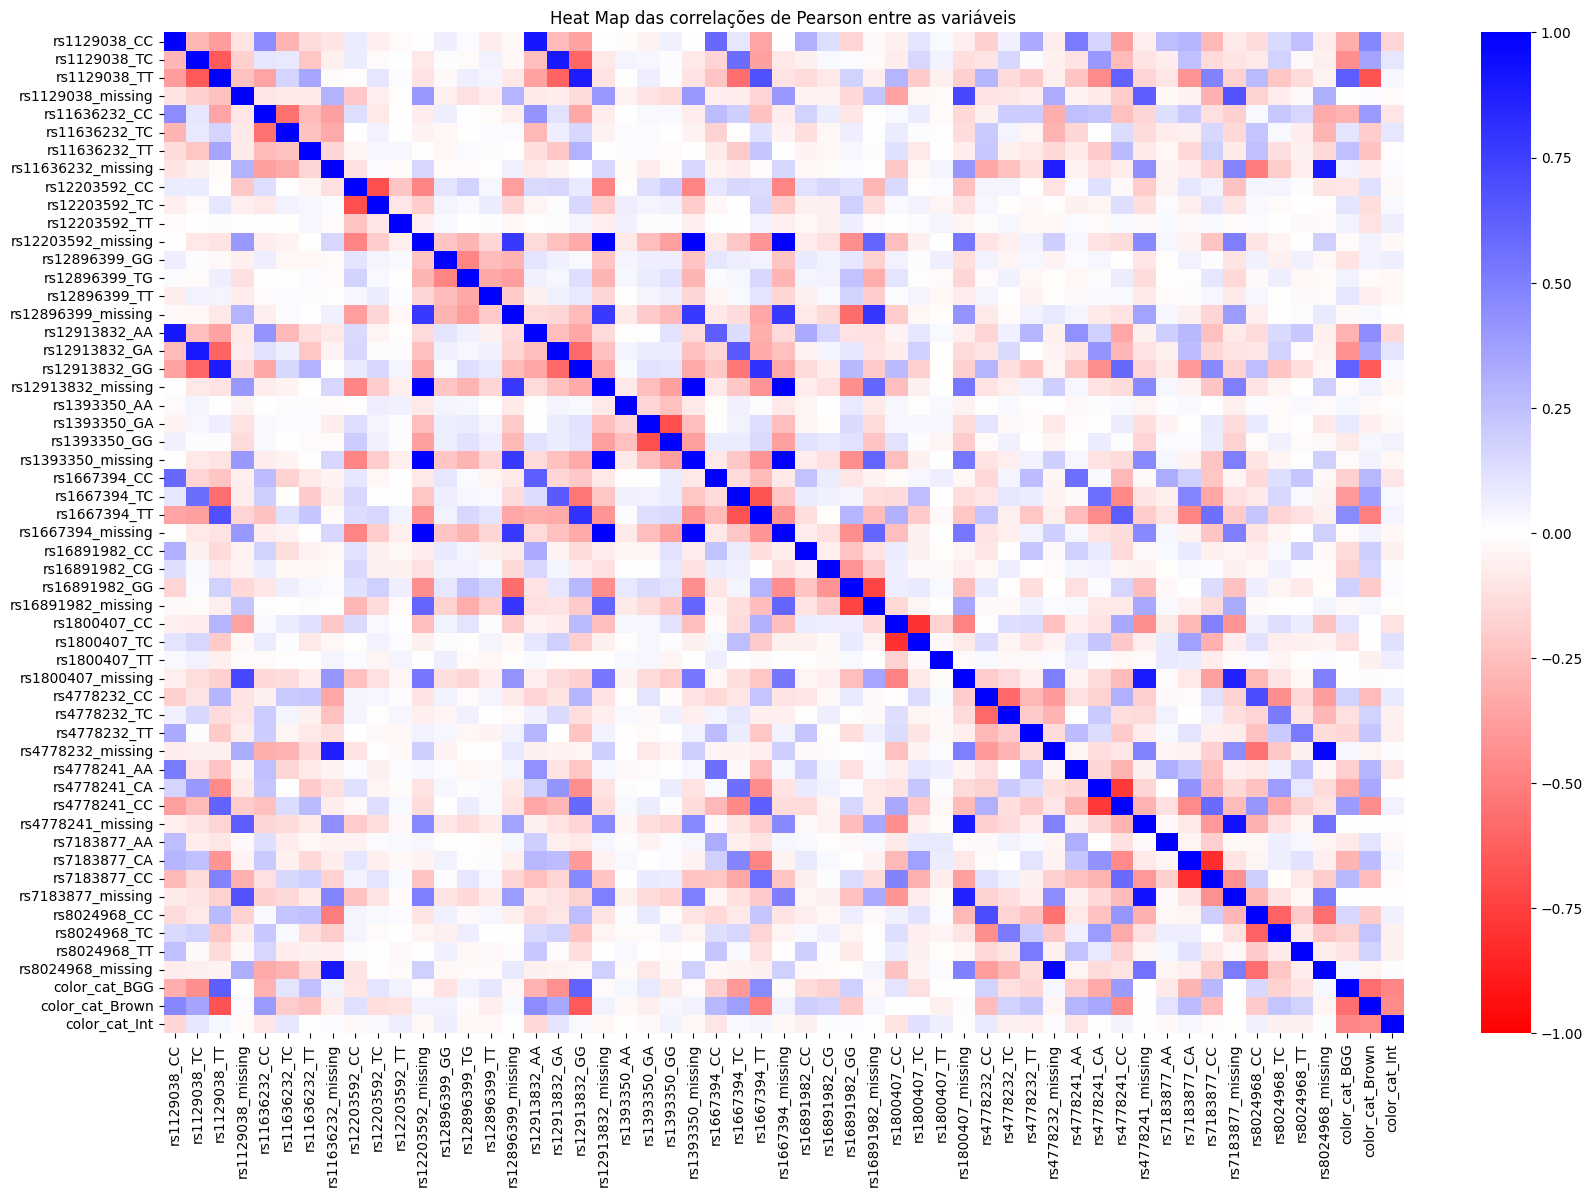

In [235]:
fig, ax = plt.subplots(figsize=(20,13))
ax = sns.heatmap(df_num.corr(), center= 0.0, vmin=-1.0, vmax=1.0, cmap="bwr_r", annot=False, fmt=".1f")
ax.set_title("Heat Map das correlações de Pearson entre as variáveis")
plt.show()

## Baseline

In [236]:
X = df_num.iloc[:, :-3]
y = df.iloc[:, -1]
y_map = y.replace({"BGG":0, "Brown":1, "Int":2})

X_train, X_test, y_train, y_test = train_test_split(X, y_map, test_size=0.33, random_state=42)

model = xgb.XGBClassifier(objective="multi:softmax", num_class=3)
model.fit(X_train, y_train)

y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)



In [237]:
print(f"A acurácia para treino foi: {accuracy_score(y_pred_train, y_train)}")
print(f"A acurácia para teste foi: {accuracy_score(y_pred_test, y_test)}")

A acurácia para treino foi: 0.8932038834951457
A acurácia para teste foi: 0.628992628992629


In [238]:
print(classification_report(y_pred_test, y_test))

              precision    recall  f1-score   support

           0       0.73      0.69      0.71       171
           1       0.78      0.73      0.76       143
           2       0.29      0.35      0.32        93

    accuracy                           0.63       407
   macro avg       0.60      0.59      0.60       407
weighted avg       0.65      0.63      0.64       407



In [239]:
print(classification_report(y_pred_train, y_train))

              precision    recall  f1-score   support

           0       0.95      0.82      0.88       339
           1       0.95      0.97      0.96       295
           2       0.75      0.91      0.82       190

    accuracy                           0.89       824
   macro avg       0.88      0.90      0.89       824
weighted avg       0.90      0.89      0.89       824



Na próxima parte serão feitos experimentos para a criação do melhor modelo preditivo, para será utilizado o dataset já tratado obtido nesta análise:

In [240]:
df.to_csv('datasets/df_ml_clean_2021.csv', index=False)